# CSCI E-89b Final Project
## What Makes For Good Leadership?

By Kacper Lewtak

# Project Summary

As the title suggests, this project looks to search through employee reviews and determine whether or not we might be able to extract some knowledge about whether or not we can determine what makes for a good workplace leader. This is to be accomplished by extracting sentiments and topics, and performing clustering on the data across a variety of categories.

The dataset used for this project is a collection of over 8 million employee reviews which has been scraped from the website Glassdoor, made available on Kaggle. This is a diverse dataset and contains ordinal, categorical, textual, and numerical datatypes.

Ultimately, this project serves to attempt to answer the following questions:

- What makes a workplace good or bad?
- Are there indicators for what a good manager/ceo might be?

# Description Of Methods

Text preprocessing and exploratory data analysis are all completed in a manual fashion for explainability, with tokenization, lemmatization, and stop word removal being handled by the SpaCy package. Preprocessing is handled in two stages. The first stage primarily focuses on cleaning the dataset as a whole. I handle the removal of unnecessary columns, handling of problematic NaN values, and the cleaning of text columns which may contain information which is desired, but mixed with text that holds no value. I note here that I leave many instances of NaN values in the dataframe as their removal would result in too much dataset loss. Instead I utilize filtering to selectively find the necessary data in order to populate data subsets.

The EDA performed is done so using both WordClouds and the plotting of distributions. I wordclouds are well suited to this topic as we are handling a question which has a largely subjective aspect to it. The "goodness" of leadership can be categorized in many different ways, and can be industry dependent. In order to keep the realistically keep this project within scope, I will only be performing analyses at a higher level. However, I must acknowledge that there is significant depth to this dataset, for which a wide variety of methods could be used.

For this project I primarily leverage LDA topic modeling to come to my conclusions. Sentiment analysis was briefly considered, however given that my dataset already contains categories in which reviewers could leave positive/negative remarks or ratings, I found this to be redundant. Instead I opt for the modeling of topics and using the existing categories as filters in order to more finely inspect which aspects of leadership individuals liked or disliked the most.



# Overview of the Data & Import

As mentioned before, the dataset contains a variety of data types. Here is the overview of the dataset.

| Column Name | Data Type | Description |
|---|---|---|
| Rating | Numerical | The is an all-encompassing value which represents how well or poorly the employee percieved the job as a whole. |
| Title | Text | This is the title for their written review. |
| Status | Ordinal | This is the employee's current employment status for the given position they are reviewing, as well as how long they have been employed for. |
| Pros | Text | Positive aspects of the job as described by the employee. |
| Cons | Text | Negative aspects of the job as described by the employee. |
| Advice | Text | Suggestions from the employee as to how either the company or leadership could improve or change. |
| Recommend | Categorical | How strongly the employee would or would not recommend that someone work their given posoition at the company. |
| CEO Approval | Categorical | How strongly the employee approves of the CEO at the time of their employment. |
| Business Outlook | Categorical | Whether or not the employee believes the company will perform into the future. |
| Career Opportunities | Numerical | A rating of how many opportunities for career advancement the employee feels that the company provides. |
| Compensation & Benefits | Numerical | The employees rating of how good or poor they believe the compensation is for their position. |
| Senior Management | Numerical | A rating of how good the management is at the company. |
| Work/Life Balance | Numerical | A rating of how well the job balances work time with personal time, according to the employee.
| Culture & Values | Numerical | A rating of a company's work culture and values, according to the employee. |
| Diversity & Inclusion | Numerical | A rating of how diverse and inclusive the employee believes the company to be. |
| Firm Link | Text | A hyperlink to the actual employee review. |
| Date | Temporal | The date which the review was posted to Glassdoor. |
| Job | Categorical | The job title which the employee has/had at the time of the review. |
| Index | NaN | Unknown column. Contains all NaN values and will be dropped |

All told, there are 19 columns across almost 10 million reviews. Some of the columns will be dropped, such as Index, as it does not provide meaningful information. For this project, most of the work will be focused on leveraging the text in the Pros and Cons columns, with clustering being coded by the other review metrics.

In [ ]:
# Library Imports

# File Management
import zipfile
import shutil
import os
import json

# Utility
import pandas as pd
import numpy as np
from re import I
from tqdm import tqdm
tqdm.pandas(position=0, leave=True)

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Language-specific EDA
!pip install wordcloud --quiet
from wordcloud import WordCloud

# Multithreaded processing
import multiprocessing as mp
num_cores = mp.cpu_count()

# Dataset Retrieval
import kagglehub

# Data Preparation
from sklearn.preprocessing import OneHotEncoder
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from spacy.tokens import Doc
from spacy.matcher import Matcher
nlp = spacy.load("en_core_web_sm")
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Multiprocessing
import multiprocessing as mp

# Topic Modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
import gensim
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel
from IPython.display import display, HTML

In [ ]:
# Download latest version
path = kagglehub.dataset_download("davidgauthier/glassdoor-job-reviews-2")

print("Path to dataset files:", path)

100%|██████████| 1.00G/1.00G [00:10<00:00, 105MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/davidgauthier/glassdoor-job-reviews-2/versions/3


In [ ]:
# Loading kaggle dataset
csv_file_path = os.path.join(path, 'all_reviews.csv')

df = pd.read_csv(csv_file_path)
df.head()

<ipython-input-3-5b76598b6c85>:4: DtypeWarning: Columns (5,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)


rating                                              title  \
0     5.0                                               Good   
1     4.0                                               Good   
2     4.0  Supervising the manufacturing the processes, e...   
3     1.0                                           terrible   
4     4.0                  It could be so good, but it isn’t   

                                 status  \
0  Current Employee, more than 10 years   
1     Former Employee, less than 1 year   
2    Current Employee, more than 1 year   
3    Current Employee, more than 1 year   
4   Current Employee, more than 3 years   

                                                pros  \
0                Knowledge gain of complete  project   
1            Good work,good work , flexible, support   
2  This company is a best opportunity for me to l...   
3                     I wish there were some to list   
4  Fast Paced. Endless challenges. Inclusive envi...   

                                                cons advice Recommend  \
0              Financial growth  and personal growth    NaN         v   
1   Good,work, flexible,good support, good team work    NaN         v   
2  Monthly Target work,Maintain production schedu...    NaN         v   
3                              too many to list here    NaN         x   
4  The biggest perk of the job provides no value ...    NaN         o   

  CEO Approval Business Outlook Career Opportunities  \
0            o                v                    3   
1            o                o                    4   
2            o                v                    2   
3            x                x                  1.0   
4            o                o                  3.0   

  Compensation and Benefits Senior Management Work/Life Balance  \
0                         3                 3                 3   
1                         4                 4                 4   
2                         3                 2                 2   
3                       3.0               1.0               3.0   
4                       3.0               3.0               1.0   

   Culture & Values  Diversity & Inclusion  \
0               3.0                    3.0   
1               4.0                    4.0   
2               2.0                    2.0   
3               1.0                    NaN   
4               4.0                    5.0   

                                           firm_link           date  \
0  Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm  Nov 19, 2022    
1  Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm  Jan 29, 2022    
2  Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm  Aug 12, 2021    
3  https://www.glassdoor.com/Reviews/Calgary-Flam...  Sep 24, 2020    
4  https://www.glassdoor.com/Reviews/Calgary-Flam...  Mar 25, 2023    

                         job  index  
0             Manager Design    NaN  
1         Anonymous Employee    NaN  
2        Production Engineer    NaN  
3   Senior Account Executive    NaN  
4          Assistant Manager    NaN

# Data Cleaning

There are several cleaning steps taken in order to both eliminate any redundant entries, thus reducing dimensionality, as well as making the categorical variables accessible for analysis.

To start, I one-hot encode the categorical columns `Recommend`, `CEO Approval`, and `Business Outlook`. This will allow for easier coloring of clusters later on.

Next is the cleaning of the `firm_link` column. For this project we are not particularly interested in the direct link to the review, so instead I reduce the link down to only the company name. This allows for additional clustering and labeling methods later in the project.

The `Date` column is then properly formatted to be a pandas datetime object.

The `Status` text is also cleaned as there are several entries which contain extraneous words which do not add any value. Removing those words provides additional usable categories and permits us to consider employee reviews across a temporal dimension.



One-hot encoding Recommend, CEO Approval, and Business Outlook categories

In [ ]:
# One hot encoding only the Recommend, CEO Approval and Business Outlook columns
encoder = OneHotEncoder(handle_unknown='ignore')
encoded_columns = encoder.fit_transform(df[['Recommend', 'CEO Approval', 'Business Outlook']])

df_encoded = pd.DataFrame(encoded_columns.toarray(), columns=encoder.get_feature_names_out(['Recommend', 'CEO Approval', 'Business Outlook']))
df_encoded.head()

Recommend_o  Recommend_v  Recommend_x  Recommend_nan  CEO Approval_o  \
0          0.0          1.0          0.0            0.0             1.0   
1          0.0          1.0          0.0            0.0             1.0   
2          0.0          1.0          0.0            0.0             1.0   
3          0.0          0.0          1.0            0.0             0.0   
4          1.0          0.0          0.0            0.0             1.0   

   CEO Approval_r  CEO Approval_v  CEO Approval_x  CEO Approval_nan  \
0             0.0             0.0             0.0               0.0   
1             0.0             0.0             0.0               0.0   
2             0.0             0.0             0.0               0.0   
3             0.0             0.0             1.0               0.0   
4             0.0             0.0             0.0               0.0   

   Business Outlook_o  Business Outlook_r  Business Outlook_v  \
0                 0.0                 0.0                 1.0   
1                 1.0                 0.0                 0.0   
2                 0.0                 0.0                 1.0   
3                 0.0                 0.0                 0.0   
4                 1.0                 0.0                 0.0   

   Business Outlook_x  Business Outlook_nan  
0                 0.0                   0.0  
1                 0.0                   0.0  
2                 0.0                   0.0  
3                 1.0                   0.0  
4                 0.0                   0.0

In [ ]:
# Changing column endings based on following: v - Positive, r - Mild, x - Negative, o - No opinion
df_encoded.columns = df_encoded.columns.str.replace('Recommend_o', 'Recommend_No_Opinion')
df_encoded.columns = df_encoded.columns.str.replace('Recommend_v', 'Recommend_Positive')
df_encoded.columns = df_encoded.columns.str.replace('Recommend_x', 'Recommend_Negative')
df_encoded.columns = df_encoded.columns.str.replace('CEO Approval_o', 'CEO Approval_No_Opinion')
df_encoded.columns = df_encoded.columns.str.replace('CEO Approval_v', 'CEO Approval_Positive')
df_encoded.columns = df_encoded.columns.str.replace('CEO Approval_x', 'CEO Approval_Negative')
df_encoded.columns = df_encoded.columns.str.replace('CEO Approval_r', 'CEO Approval_Mild')
df_encoded.columns = df_encoded.columns.str.replace('Business Outlook_o', 'Business Outlook_No_Opinion')
df_encoded.columns = df_encoded.columns.str.replace('Business Outlook_v', 'Business Outlook_Positive')
df_encoded.columns = df_encoded.columns.str.replace('Business Outlook_x', 'Business Outlook_Negative')
df_encoded.columns = df_encoded.columns.str.replace('Business Outlook_r', 'Business Outlook_Mild')
df_encoded.head()

Recommend_No_Opinion  Recommend_Positive  Recommend_Negative  \
0                   0.0                 1.0                 0.0   
1                   0.0                 1.0                 0.0   
2                   0.0                 1.0                 0.0   
3                   0.0                 0.0                 1.0   
4                   1.0                 0.0                 0.0   

   Recommend_nan  CEO Approval_No_Opinion  CEO Approval_Mild  \
0            0.0                      1.0                0.0   
1            0.0                      1.0                0.0   
2            0.0                      1.0                0.0   
3            0.0                      0.0                0.0   
4            0.0                      1.0                0.0   

   CEO Approval_Positive  CEO Approval_Negative  CEO Approval_nan  \
0                    0.0                    0.0               0.0   
1                    0.0                    0.0               0.0   
2                    0.0                    0.0               0.0   
3                    0.0                    1.0               0.0   
4                    0.0                    0.0               0.0   

   Business Outlook_No_Opinion  Business Outlook_Mild  \
0                          0.0                    0.0   
1                          1.0                    0.0   
2                          0.0                    0.0   
3                          0.0                    0.0   
4                          1.0                    0.0   

   Business Outlook_Positive  Business Outlook_Negative  Business Outlook_nan  
0                        1.0                        0.0                   0.0  
1                        0.0                        0.0                   0.0  
2                        1.0                        0.0                   0.0  
3                        0.0                        1.0                   0.0  
4                        0.0                        0.0                   0.0

In [ ]:
# Merge encoded columns into original df and drop the original columns
df = pd.concat([df, df_encoded], axis=1)
df = df.drop(columns=['Recommend', 'CEO Approval', 'Business Outlook'])
df.head()

rating                                              title  \
0     5.0                                               Good   
1     4.0                                               Good   
2     4.0  Supervising the manufacturing the processes, e...   
3     1.0                                           terrible   
4     4.0                  It could be so good, but it isn’t   

                                 status  \
0  Current Employee, more than 10 years   
1     Former Employee, less than 1 year   
2    Current Employee, more than 1 year   
3    Current Employee, more than 1 year   
4   Current Employee, more than 3 years   

                                                pros  \
0                Knowledge gain of complete  project   
1            Good work,good work , flexible, support   
2  This company is a best opportunity for me to l...   
3                     I wish there were some to list   
4  Fast Paced. Endless challenges. Inclusive envi...   

                                                cons advice  \
0              Financial growth  and personal growth    NaN   
1   Good,work, flexible,good support, good team work    NaN   
2  Monthly Target work,Maintain production schedu...    NaN   
3                              too many to list here    NaN   
4  The biggest perk of the job provides no value ...    NaN   

  Career Opportunities Compensation and Benefits Senior Management  \
0                    3                         3                 3   
1                    4                         4                 4   
2                    2                         3                 2   
3                  1.0                       3.0               1.0   
4                  3.0                       3.0               3.0   

  Work/Life Balance  ...  CEO Approval_No_Opinion  CEO Approval_Mild  \
0                 3  ...                      1.0                0.0   
1                 4  ...                      1.0                0.0   
2                 2  ...                      1.0                0.0   
3               3.0  ...                      0.0                0.0   
4               1.0  ...                      1.0                0.0   

  CEO Approval_Positive CEO Approval_Negative CEO Approval_nan  \
0                   0.0                   0.0              0.0   
1                   0.0                   0.0              0.0   
2                   0.0                   0.0              0.0   
3                   0.0                   1.0              0.0   
4                   0.0                   0.0              0.0   

   Business Outlook_No_Opinion  Business Outlook_Mild  \
0                          0.0                    0.0   
1                          1.0                    0.0   
2                          0.0                    0.0   
3                          0.0                    0.0   
4                          1.0                    0.0   

   Business Outlook_Positive  Business Outlook_Negative  Business Outlook_nan  
0                        1.0                        0.0                   0.0  
1                        0.0                        0.0                   0.0  
2                        1.0                        0.0                   0.0  
3                        0.0                        1.0                   0.0  
4                        0.0                        0.0                   0.0  

[5 rows x 30 columns]

Cleaning the firm_link column

In [ ]:
# Removing all 'Reviews/' and any text that comes before it from firm_link
df['firm_link'] = df['firm_link'].str.split('Reviews/').str[1]

# Removing all .htm and any text that follows from firm_link
df['firm_link'] = df['firm_link'].str.split('.htm').str[0]

# Removing all '-Reviews-E' and any text that follows from firm_link
df['firm_link'] = df['firm_link'].str.split('-Reviews-E').str[0]

# Resulting values should only contain the company name
df.firm_link

0                            Baja-Steel-and-Fence
1                            Baja-Steel-and-Fence
2                            Baja-Steel-and-Fence
3                                  Calgary-Flames
4                                  Calgary-Flames
                            ...                  
9901884    Victoria-Inn-Hotel-&-Convention-Centre
9901885    Victoria-Inn-Hotel-&-Convention-Centre
9901886    Victoria-Inn-Hotel-&-Convention-Centre
9901887    Victoria-Inn-Hotel-&-Convention-Centre
9901888    Victoria-Inn-Hotel-&-Convention-Centre
Name: firm_link, Length: 9901889, dtype: object

In [ ]:
df.firm_link.value_counts()

firm_link
Amazon                            163396
Tata-Consultancy-Services         107218
Walmart                           102152
Cognizant-Technology-Solutions     84171
McDonald-s                         76777
                                   ...  
Technology-Consultant                  1
Geasar                                 1
HBank-Technologies                     1
Kit-A-Kid                              1
Ohio-Imaging                           1
Name: count, Length: 34374, dtype: int64

Properly formatting the date column

In [ ]:
# Formatting date column to pd datetime
# Strip leading/trailing spaces before converting to datetime
df['date'] = df['date'].str.strip()
df['date'] = pd.to_datetime(df['date'], format='%b %d, %Y', errors='coerce')

# Check for NaT (Not a Time) values after conversion, which indicate parsing errors
print(f'Number of rows without a proper date:  {df["date"].isnull().sum()}')

# Dropping NaT rows
df = df.dropna(subset=['date'])

df.head()

Number of rows without a proper date:  171


rating                                              title  \
0     5.0                                               Good   
1     4.0                                               Good   
2     4.0  Supervising the manufacturing the processes, e...   
3     1.0                                           terrible   
4     4.0                  It could be so good, but it isn’t   

                                 status  \
0  Current Employee, more than 10 years   
1     Former Employee, less than 1 year   
2    Current Employee, more than 1 year   
3    Current Employee, more than 1 year   
4   Current Employee, more than 3 years   

                                                pros  \
0                Knowledge gain of complete  project   
1            Good work,good work , flexible, support   
2  This company is a best opportunity for me to l...   
3                     I wish there were some to list   
4  Fast Paced. Endless challenges. Inclusive envi...   

                                                cons advice  \
0              Financial growth  and personal growth    NaN   
1   Good,work, flexible,good support, good team work    NaN   
2  Monthly Target work,Maintain production schedu...    NaN   
3                              too many to list here    NaN   
4  The biggest perk of the job provides no value ...    NaN   

  Career Opportunities Compensation and Benefits Senior Management  \
0                    3                         3                 3   
1                    4                         4                 4   
2                    2                         3                 2   
3                  1.0                       3.0               1.0   
4                  3.0                       3.0               3.0   

  Work/Life Balance  ...  CEO Approval_No_Opinion  CEO Approval_Mild  \
0                 3  ...                      1.0                0.0   
1                 4  ...                      1.0                0.0   
2                 2  ...                      1.0                0.0   
3               3.0  ...                      0.0                0.0   
4               1.0  ...                      1.0                0.0   

  CEO Approval_Positive CEO Approval_Negative CEO Approval_nan  \
0                   0.0                   0.0              0.0   
1                   0.0                   0.0              0.0   
2                   0.0                   0.0              0.0   
3                   0.0                   1.0              0.0   
4                   0.0                   0.0              0.0   

   Business Outlook_No_Opinion  Business Outlook_Mild  \
0                          0.0                    0.0   
1                          1.0                    0.0   
2                          0.0                    0.0   
3                          0.0                    0.0   
4                          1.0                    0.0   

   Business Outlook_Positive  Business Outlook_Negative  Business Outlook_nan  
0                        1.0                        0.0                   0.0  
1                        0.0                        0.0                   0.0  
2                        1.0                        0.0                   0.0  
3                        0.0                        1.0                   0.0  
4                        0.0                        0.0                   0.0  

[5 rows x 30 columns]

Cleaning the status column

In [ ]:
# force show all rows
pd.set_option('display.max_rows', None)
df.status.value_counts()

status
Current Employee                                               2328379
Former Employee                                                1617824
Current Employee, more than 1 year                              974663
Former Employee, more than 1 year                               830200
Current Employee, more than 3 years                             730789
Current Employee, less than 1 year                              706815
Former Employee, less than 1 year                               588296
Former Employee, more than 3 years                              527113
Current Employee, more than 5 years                             459989
Former Employee, more than 5 years                              293072
Current Employee, more than 10 years                            290813
Current Employee, more than 8 years                             224177
Former Employee, more than 10 years                             180566
Former Employee, more than 8 years                              139208
Former Intern, less than 1 year                                   1645
Former Intern                                                     1281
Former Contractor                                                  788
Former Contractor, less than 1 year                                730
Current Contractor                                                 562
Former Contractor, more than 1 year                                498
Current Intern, less than 1 year                                   482
Current Intern                                                     451
Current Contractor, less than 1 year                               423
Current Contractor, more than 1 year                               319
Former Intern, more than 1 year                                    236
Former Freelancer                                                  207
Current Freelancer                                                 188
Former Temporary Employee                                          182
Former Contractor, more than 3 years                               179
Current Contractor, more than 3 years                              160
Current Temporary Employee                                         152
Former Freelancer, less than 1 year                                119
Current Intern, more than 1 year                                   108
Current Freelancer, less than 1 year                                88
Former Contractor, more than 5 years                                79
Former Freelancer, more than 1 year                                 77
Current Contractor, more than 5 years                               74
Formerly Self-employed                                              57
Former Temporary Employee, less than 1 year                         56
Current Freelancer, more than 1 year                                54
Currently Self-employed                                             52
Current Contractor, more than 10 years                              44
Current Contractor, more than 8 years                               44
Current Freelancer, more than 3 years                               35
Former Contractor, more than 8 years                                34
Former Contractor, more than 10 years                               33
Former Intern, more than 3 years                                    31
Current Temporary Employee, less than 1 year                        29
KEY NOT FOUND: jobLine.seasonal-former                              26
Former Freelancer, more than 3 years                                25
Former Temporary Employee, more than 1 year                         24
Current Freelancer, more than 8 years                               22
KEY NOT FOUND: jobLine.seasonal-current                             22
Current Freelancer, more than 5 years                               17
Current Intern, more than 3 years                                   16
Current Freelancer, more than 10 years                              16
Former Freelancer

In [ ]:
# List comprehension for removing all instances of 'jobLine.' and all text preceeding it
# but only if the text contains that string
df['status'] = [x.split('jobLine.')[1] if 'jobLine.' in x else x for x in df['status']]
df.status.value_counts()

status
Current Employee                                 2328379
Former Employee                                  1617824
Current Employee, more than 1 year                974663
Former Employee, more than 1 year                 830200
Current Employee, more than 3 years               730789
Current Employee, less than 1 year                706815
Former Employee, less than 1 year                 588296
Former Employee, more than 3 years                527113
Current Employee, more than 5 years               459989
Former Employee, more than 5 years                293072
Current Employee, more than 10 years              290813
Current Employee, more than 8 years               224177
Former Employee, more than 10 years               180566
Former Employee, more than 8 years                139208
Former Intern, less than 1 year                     1645
Former Intern                                       1281
Former Contractor                                    788
Former Contractor, less than 1 year                  730
Current Contractor                                   562
Former Contractor, more than 1 year                  498
Current Intern, less than 1 year                     482
Current Intern                                       451
Current Contractor, less than 1 year                 423
Current Contractor, more than 1 year                 319
Former Intern, more than 1 year                      236
Former Freelancer                                    207
Current Freelancer                                   188
Former Temporary Employee                            182
Former Contractor, more than 3 years                 179
Current Contractor, more than 3 years                160
Current Temporary Employee                           152
Former Freelancer, less than 1 year                  119
Current Intern, more than 1 year                     108
Current Freelancer, less than 1 year                  88
Former Contractor, more than 5 years                  79
Former Freelancer, more than 1 year                   77
Current Contractor, more than 5 years                 74
Formerly Self-employed                                57
Former Temporary Employee, less than 1 year           56
Current Freelancer, more than 1 year                  54
Currently Self-employed                               52
Current Contractor, more than 10 years                44
Current Contractor, more than 8 years                 44
Current Freelancer, more than 3 years                 35
Former Contractor, more than 8 years                  34
Former Contractor, more than 10 years                 33
Former Intern, more than 3 years                      31
Current Temporary Employee, less than 1 year          29
seasonal-former                                       26
Former Freelancer, more than 3 years                  25
Former Temporary Employee, more than 1 year           24
Current Freelancer, more than 8 years                 22
seasonal-current                                      22
Current Freelancer, more than 5 years                 17
Current Intern, more than 3 years                     16
Current Freelancer, more than 10 years                16
Former Freelancer, more than 10 years                 15
Former Freelancer, more than 5 years                  13
Former Freelancer, more than 8 years                  12
Current Temporary Employee, more than 3 years         11
Current Temporary Employee, more than 1 year          10
per_diem-former                                       10
seasonal-former, less than 1 year                      7
per_diem-current                                       6
reserve-former                                         6
Former Intern, more than 5 years                       5
reserve-current                                        5
Current Intern, more than 8 years                      5
Former Apprentice                                      4
Current Intern, more than 5 years                      4
For

In [ ]:
pd.set_option('display.max_rows', 40)
df.job.value_counts()

job
Anonymous Employee                                        1704869
                                                           682948
Sales Associate                                            155604
Software Engineer                                          147930
Manager                                                    127789
                                                           ...   
Women’s Health Nurse Practitioner                               1
Reproductive Health Care Assistant                              1
Director of Institutional Giving                                1
Medical Records and Health Center Operations Assistant          1
Radiography Clinical Director                                   1
Name: count, Length: 440593, dtype: int64

Handling NaN values

In [ ]:
df.isna().sum()

rating                               0
title                            39253
status                               0
pros                                17
cons                                63
advice                         9901705
Career Opportunities           1848091
Compensation and Benefits      1877920
Senior Management              1975295
Work/Life Balance              1894319
Culture & Values               2246602
Diversity & Inclusion          6544111
firm_link                            0
date                                 0
job                                  0
index                          9740100
Recommend_No_Opinion                 0
Recommend_Positive                   0
Recommend_Negative                   0
Recommend_nan                        0
CEO Approval_No_Opinion              0
CEO Approval_Mild                    0
CEO Approval_Positive                0
CEO Approval_Negative                0
CEO Approval_nan                     0
Business Outlook_No_Opinion          0
Business Outlook_Mild                0
Business Outlook_Positive            0
Business Outlook_Negative            0
Business Outlook_nan                 0
dtype: int64

In [ ]:
# Given the large amount of NaN values present in advice, index and diversity & inclusion
# I will choose to drop those columns from the dataset
df = df.drop(columns=['advice', 'index', 'Diversity & Inclusion'])

# I will also drop NaN rows in Pros and Cons
df = df.dropna(subset=['pros', 'cons'])

In [ ]:
# Converting 'Senior Management' to integers, handling values outside the 1-5 range
df['Senior Management'] = pd.to_numeric(df['Senior Management'], errors='coerce')
df['Senior Management'] = df['Senior Management'].astype('Int64')

# Replace values outside the valid range with NaN
df.loc[df['Senior Management'] < 1, 'Senior Management'] = pd.NA
df.loc[df['Senior Management'] > 5, 'Senior Management'] = pd.NA

In [ ]:
df.shape

(9901638, 27)

# First Pass EDA

Before performing further processing the the text columns, I first take a look at the raw data by creating word clouds of the most common words in `Pros` and `Cons`. This provides an overview of what concepts employees might associate with a good or bad workplace. From these graphics, we can begin to piece together a picture that employees tend to put emphasis on the quality of their managers, the opportunities offered to them by their job, job compensation, as well as the balance between work and life.

Additional wordclouds are created by filtering for `Pros` reviews where the employee rated a 5, the highes score, and filtering for `Cons` reviews where the employee rated a 1, the lowest score. In doing so, we should be able to more clearly visualize the difference in concepts and sentiments between good vs. bad working places. These graphics build upon the trends we saw forming in the first pair of wordclouds. For highly rated jobs, we can see that employees greatly valued the work/life balance offered to them, work benefits, and a good working environment. Likewise for poorly rated jobs, we can see that employees commonly list the company, work, poor time management, and a lack of care.

Finally, I plot one last set of wordclouds. This time I take the `Pros` and `Cons` them by both highly and poorly rated CEO approval and senior management rating, respectively. From these plots we get a beginning understanding of how good leadership can contribute to the overall experience at a place of work. For approved CEOs and highly rated senior management, we can see that employees tend to mention an overall positive work experience, a good work culture, and a positive work/life balance. For negative CEO approval and low senior management scores we can see that the primary issues employees have are with the management itself. Contributing factors are bad working conditions, working hours, and payment.

Overall, there is a large amount of overlap between the two categories of reviews. As a result, things such as overall working conditions, management, work/life balance, compensation, and benefits tend to be strong indicators of whether or not an employee will rate their job well.

Generating word clouds for pros and cons columns

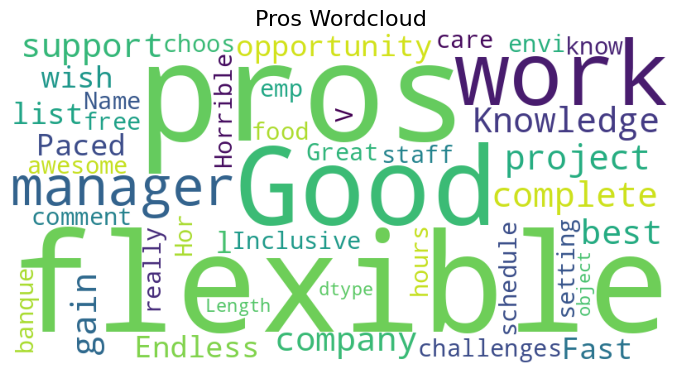

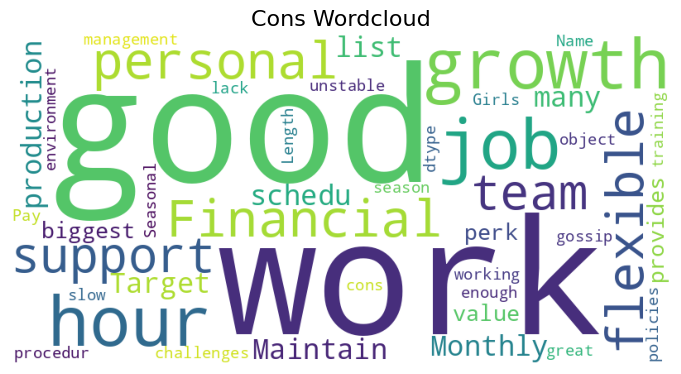

In [ ]:
# Initializing wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=300)

# Wordcloud for Pros column
wordcloud.generate(str(df['pros']))
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.title('Pros Wordcloud', fontsize=16)
plt.axis('off')
plt.tight_layout(pad=5)
plt.show()

# Wordcloud for Cons column
wordcloud.generate(str(df['cons']))
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.title('Cons Wordcloud', fontsize=16)
plt.axis('off')
plt.tight_layout(pad=5)
plt.show()

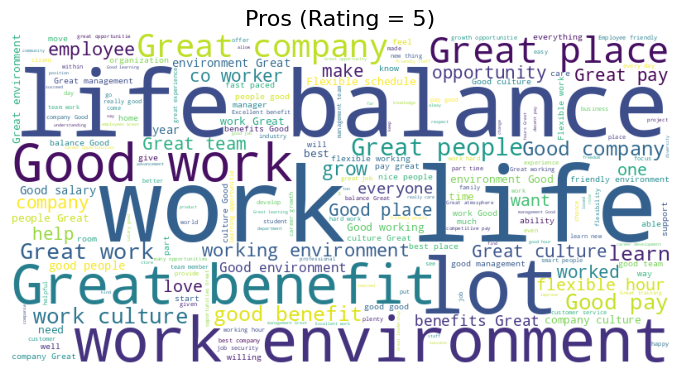

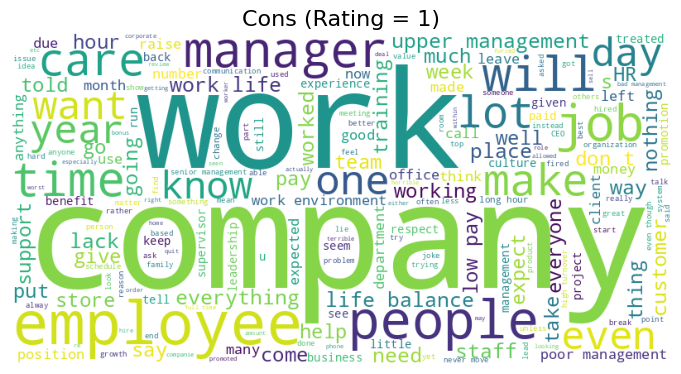

<Figure size 640x480 with 0 Axes>

In [ ]:
# Filter for pros with rating 5 and cons with rating 1
pros_5 = df[df['rating'] == 5]['pros'].astype(str)
cons_1 = df[df['rating'] == 1]['cons'].astype(str)

# Generate word clouds
wordcloud_pros_5 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(pros_5))
wordcloud_cons_1 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(cons_1))


# Wordcloud for Pros column
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud_pros_5)
plt.title('Pros (Rating = 5)', fontsize=16)
plt.axis('off')
plt.tight_layout(pad=5)
plt.show()

# Wordcloud for Pros column
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud_cons_1)
plt.title('Cons (Rating = 1)', fontsize=16)
plt.axis('off')
plt.tight_layout(pad=5)
plt.show()

plt.tight_layout(pad=3)
plt.show()

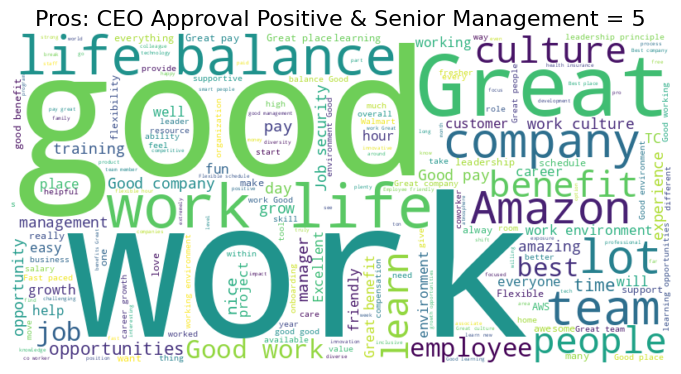

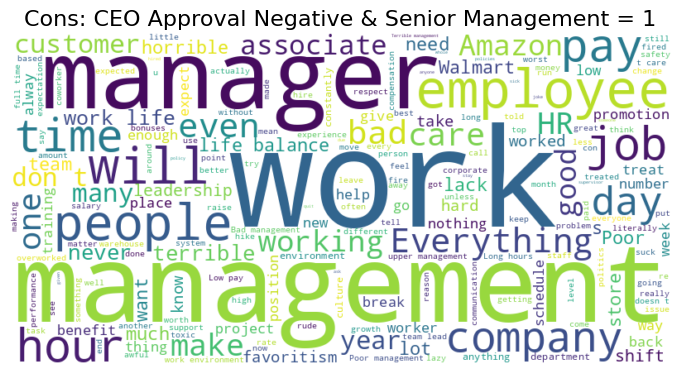

In [ ]:
# Filter for pros with CEO Approval Positive and Senior Management value of 5
pros_ceo_positive_sm_5 = df[(df['CEO Approval_Positive'] == 1) & (df['Senior Management'] == 5)]['pros'].astype(str)

# Filter for cons with CEO Approval Negative and Senior Management value of 1
cons_ceo_negative_sm_1 = df[(df['CEO Approval_Negative'] == 1) & (df['Senior Management'] == 1)]['cons'].astype(str)

# Generate word clouds
wordcloud_pros_ceo_positive_sm_5 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(pros_ceo_positive_sm_5))
wordcloud_cons_ceo_negative_sm_1 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(cons_ceo_negative_sm_1))

# Display the word clouds
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud_pros_ceo_positive_sm_5, interpolation='bilinear')
plt.title("Pros: CEO Approval Positive & Senior Management = 5", fontsize=16)
plt.axis('off')
plt.tight_layout(pad=5)
plt.show()

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud_cons_ceo_negative_sm_1, interpolation='bilinear')
plt.title("Cons: CEO Approval Negative & Senior Management = 1", fontsize=16)
plt.axis('off')
plt.tight_layout(pad=5)
plt.show()

# Text Preprocessing

Standard text preprocessing steps are applied to the `Pros` and `Cons` text. I ensure that all of the text is of type string and made lower case. The text is then tokenized and lemmatized, with stop words and punctuation being removed. I apply multiprocessing to this step as it would prove prohibitvely time consuming to process almost 10 million documents at the original ~100 doc/sec speed. With multiprocessing, this is increased to ~6000 doc/sec and allows the cell to finish in only 1 hour. Once complete, we have our preprocessed text.

In [ ]:
# Manually handling initial part of preprocessing
# Converting all text to type string
df['pros'] = df['pros'].astype(str)
df['cons'] = df['cons'].astype(str)

# Replacing any left over formatting characters from the scraped dataset
df['pros'] = df['pros'].str.replace(r'\n', ' ', regex=True)
df['cons'] = df['cons'].str.replace(r'\n', ' ', regex=True)

df['pros'] = df['pros'].str.replace(r'\t', ' ', regex=True)
df['cons'] = df['cons'].str.replace(r'\t', ' ', regex=True)

df['pros'] = df['pros'].str.replace(r'\r', ' ', regex=True)
df['cons'] = df['cons'].str.replace(r'\r', ' ', regex=True)

# Setting all text to lowercase
df['pros'] = df['pros'].str.lower()
df['cons'] = df['cons'].str.lower()

def preprocess_text(text):
  return [token.lemma_ for token in nlp(text) if not token.is_stop and not token.is_punct]

# Number of CPU cores to use
num_cores = mp.cpu_count()

# Create a multiprocessing Pool
pool = mp.Pool(processes=num_cores-1)

# Apply the preprocessing function in parallel using imap
df['pros_tokens'] = list(tqdm(pool.imap(preprocess_text, df['pros']), total=len(df['pros']), position=0, leave=True, desc="Processing Pros"))
df['cons_tokens'] = list(tqdm(pool.imap(preprocess_text, df['cons']), total=len(df['cons']), position=0, leave=True, desc="Processing Cons"))

# Close and join the pool to ensure all processes finish
pool.close()
pool.join()

df.head()

Processing Cons: 100%|██████████| 9901638/9901638 [32:17<00:00, 5111.43it/s]


rating                                              title  \
0     5.0                                               Good   
1     4.0                                               Good   
2     4.0  Supervising the manufacturing the processes, e...   
3     1.0                                           terrible   
4     4.0                  It could be so good, but it isn’t   

                                 status  \
0  Current Employee, more than 10 years   
1     Former Employee, less than 1 year   
2    Current Employee, more than 1 year   
3    Current Employee, more than 1 year   
4   Current Employee, more than 3 years   

                                                pros  \
0                knowledge gain of complete  project   
1            good work,good work , flexible, support   
2  this company is a best opportunity for me to l...   
3                     i wish there were some to list   
4  fast paced. endless challenges. inclusive envi...   

                                                cons Career Opportunities  \
0              financial growth  and personal growth                    3   
1   good,work, flexible,good support, good team work                    4   
2  monthly target work,maintain production schedu...                    2   
3                              too many to list here                  1.0   
4  the biggest perk of the job provides no value ...                  3.0   

  Compensation and Benefits Senior Management Work/Life Balance  \
0                         3                 3                 3   
1                         4                 4                 4   
2                         3                 2                 2   
3                       3.0               1.0               3.0   
4                       3.0               3.0               1.0   

   Culture & Values  ... CEO Approval_Positive CEO Approval_Negative  \
0               3.0  ...                   0.0                   0.0   
1               4.0  ...                   0.0                   0.0   
2               2.0  ...                   0.0                   0.0   
3               1.0  ...                   0.0                   1.0   
4               4.0  ...                   0.0                   0.0   

  CEO Approval_nan  Business Outlook_No_Opinion  Business Outlook_Mild  \
0              0.0                          0.0                    0.0   
1              0.0                          1.0                    0.0   
2              0.0                          0.0                    0.0   
3              0.0                          0.0                    0.0   
4              0.0                          1.0                    0.0   

   Business Outlook_Positive  Business Outlook_Negative  Business Outlook_nan  \
0                        1.0                        0.0                   0.0   
1                        0.0                        0.0                   0.0   
2                        1.0                        0.0                   0.0   
3                        0.0                        1.0                   0.0   
4                        0.0                        0.0                   0.0   

                                         pros_tokens  \
0            [knowledge, gain, complete,  , project]   
1        [good, work, good, work, flexible, support]   
2  [company, good, opportunity, learning, core, m...   
3                                       [wish, list]   
4  [fast, pace, endless, challenge, inclusive, en...   

                                         cons_tokens  
0           [financial, growth,  , personal, growth]  
1  [good, work, flexible, good, support, good, te...  
2  [monthly, target, work, maintain, production, ...  
3                                             [list]  
4  [big, perk, job, provide, value, event, base, ...  

[5 rows x 29 columns]

In [ ]:
# removing blank spaces from the tokens
df['pros_tokens'] = df['pros_tokens'].apply(lambda x: [token for token in x if token.strip()])
df['cons_tokens'] = df['cons_tokens'].apply(lambda x: [token for token in x if token.strip()])

In [ ]:
# inspecting loc 9901878 to ensure all preprocessing functioned as intended
df.loc[9901878].pros

'- fits within your schedule  - bonus pay + tip'

In [ ]:
df.loc[9901878].pros_tokens

['fit', 'schedule', 'bonus', 'pay', '+', 'tip']

In [ ]:
# Export the df in pickle
import pickle

with open('df_cscie89b.pkl', 'wb') as f:
    pickle.dump(df, f)

In [ ]:
# Copy df to google drive
!cp df_cscie89b.pkl /content/drive/MyDrive/

In [ ]:
# Copy the df from the google drive
!cp /content/drive/MyDrive/df_cscie89b.pkl df_cscie89b.pkl

In [ ]:
# Import the df in pickle
import pickle

with open('df_cscie89b.pkl', 'rb') as f:
    df = pickle.load(f)

# Further EDA

With our text columns now cleaned and prepared, we can perform additional data analysis to perhaps understand a bit more about the reviews which were written.

The immediate difference in these observations are the distinct differences between the `Pros` and the `Cons`! With the stop words removed, we are able to graph more meaningful sentiments and ideas.

The first pair of wordclouds is for all `Pros` and `Cons` reviews with no filtering applied. This provides a high level overview of what employees generally thought of their job.

The next pair of wordclouds we apply filtering to the reviews based on the overall rating that they gave to their job, with 5 being the highest and 1 being the lowest. From these graphs we can conclude that most employees focused on the overall work experience and work environment. With common words like 'great, people, fun, opportunity, environment, knowledge, growth' all supporting the notion that a positive work experience, coupled with good career opportunities, makes for a good job. On the contrary, we can see that for poorly rated jobs, the commonly used words were 'toxic, work, environment, management, overworked, bullying, life, balance'. These all point towards a negative working experience.

The final pair of wordclouds consists of the `Pros` and `Cons` columns being filtered by both positive and negative CEO approval and senior management rating, respectively. Like before, this is done in an attempt to understand the relationship between a well percieved job and work leadership.

For the pros, we can see that in most cases employees spoke well of upper management with words like 'good, growth, team, work, feel, nice'. This seems to suggest that good leadership can not only provide a sense of unity and teamwork, but also enable a positive work environment.

For the cons, we see that many of the employees focused on aspects like 'salary, poor, concern, worklife, balance, culture, pressure, politics'. Together, these paint a picture of an upper management which does not value their workers.

In [ ]:
# Mostly similar code to before, just now functionized to make it cleaner
# This function essentially creates our wordclouds, taking the text and a relevant title
def generate_wordcloud(text, title):
  """Generates and displays a word cloud from the given text.

  Args:
    text: The text to generate the word cloud from.
    title: The title for the word cloud plot.
  """
  wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=300).generate(str(text))
  plt.figure(figsize=(8, 8), facecolor=None)
  plt.imshow(wordcloud)
  plt.title(title, fontsize=16)
  plt.axis('off')
  plt.tight_layout(pad=5)
  plt.show()


# Here we take the dataframe and generate wordclouds based on filtering rules
def analyze_pros_cons(df):
    """Performs text-based exploratory data analysis on the Pros and Cons columns.

    Args:
        df: pandas DataFrame containing 'pros', 'cons', 'rating', 'CEO Approval', and 'Senior Management' columns.
    """

    # Generate word clouds for the entire dataset
    generate_wordcloud(df['pros_tokens'], 'Pros Wordcloud (Overall)')
    generate_wordcloud(df['cons_tokens'], 'Cons Wordcloud (Overall)')
    print('')

    # Analyze based on rating
    pros_5 = df[df['rating'] == 5]['pros_tokens']
    cons_1 = df[df['rating'] == 1]['cons_tokens']
    generate_wordcloud(pros_5, 'Pros Wordcloud (Rating = 5)')
    generate_wordcloud(cons_1, 'Cons Wordcloud (Rating = 1)')
    print('')

    # Analyze based on CEO Approval
    pros_ceo_positive_sm_5 = df[(df['CEO Approval_Positive'] == 1) & (df['Senior Management'] == 5)]['pros_tokens']
    cons_ceo_negative_sm_1 = df[(df['CEO Approval_Negative'] == 1) & (df['Senior Management'] == 1)]['cons_tokens']
    generate_wordcloud(pros_ceo_positive_sm_5, 'Pros Wordcloud (CEO Approval Positive & Senior Management = 5)')
    generate_wordcloud(cons_ceo_negative_sm_1, 'Cons Wordcloud (CEO Approval Negative & Senior Management = 1)')


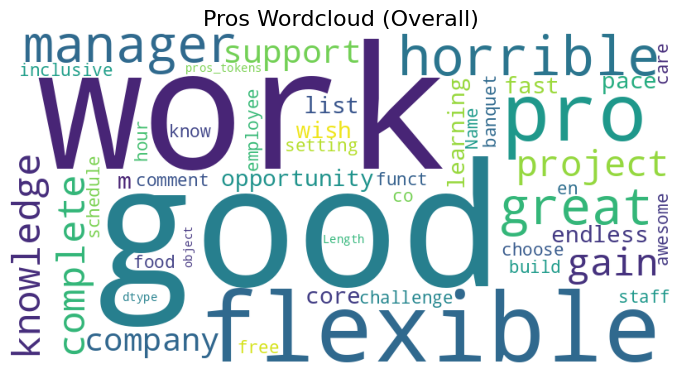

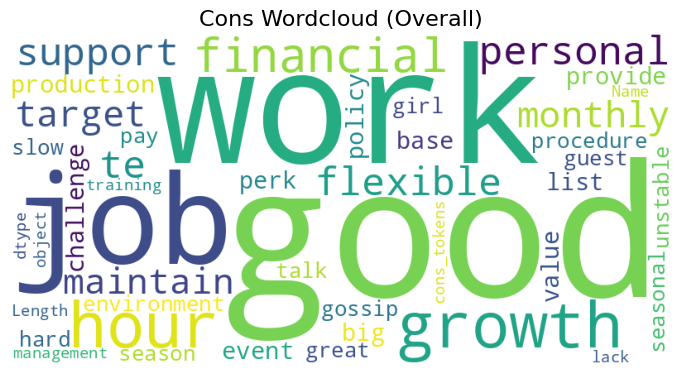

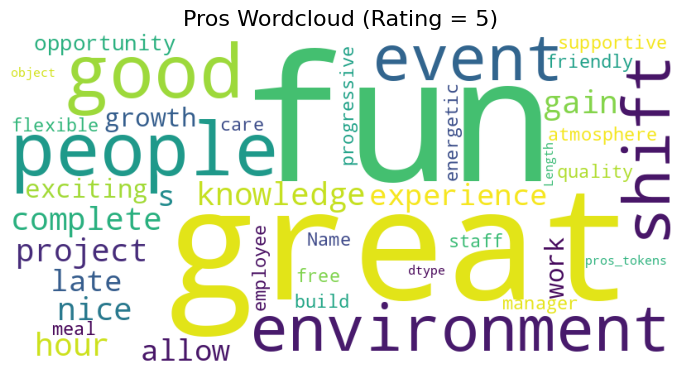

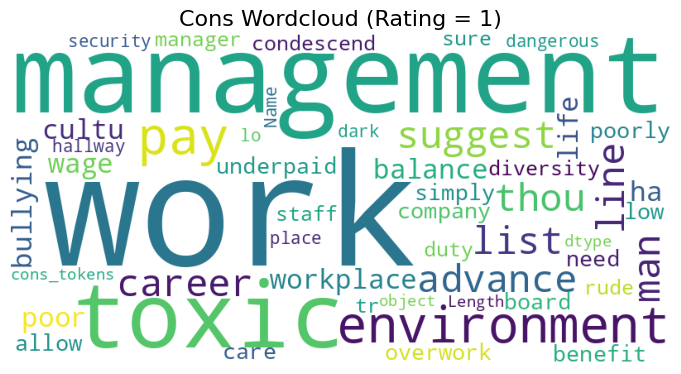

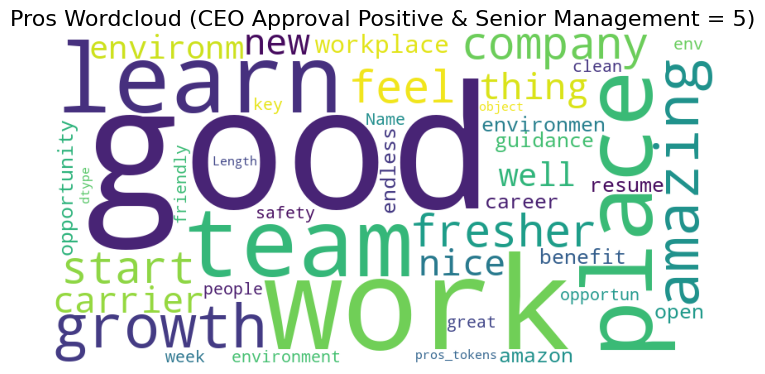

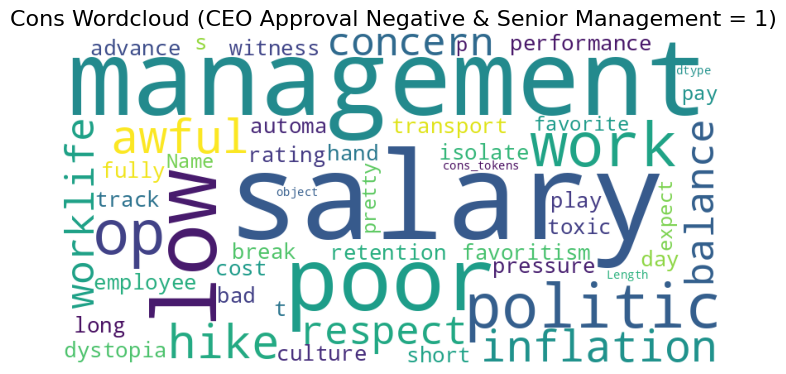

In [ ]:
analyze_pros_cons(df)

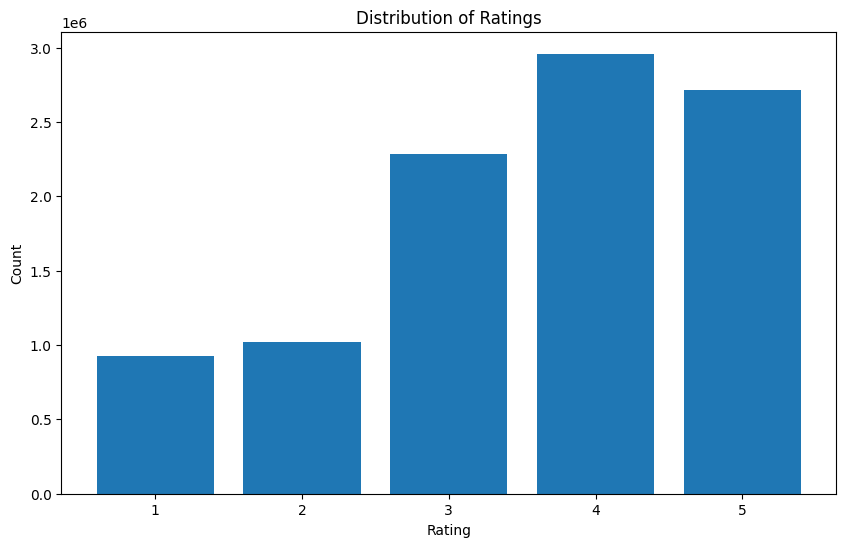

In [ ]:
# Plotting distribution of Ratings
plt.figure(figsize=(10, 6))
plt.bar(df['rating'].value_counts().index, df['rating'].value_counts()) # Call value_counts()
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()

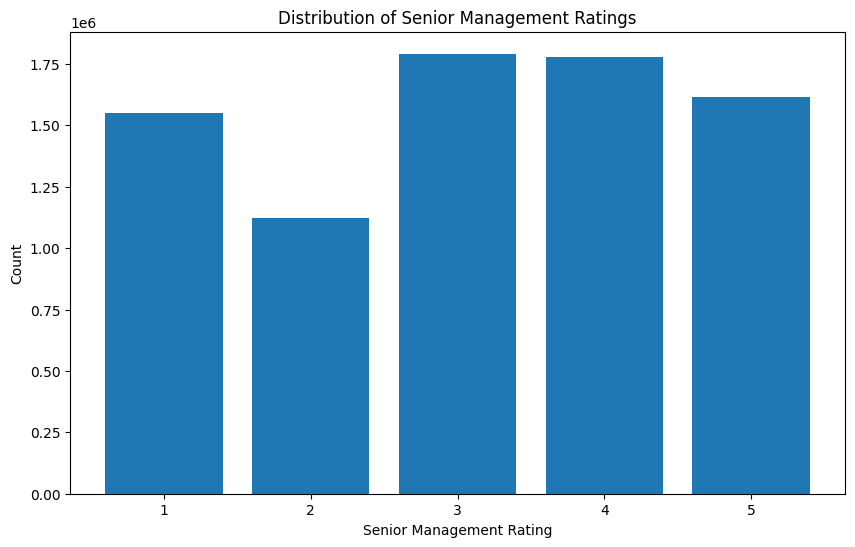

In [ ]:
# Plotting distribution of Senior Management Ratings
plt.figure(figsize=(10, 6))
plt.bar(df['Senior Management'].value_counts().index, df['Senior Management'].value_counts()) # Call value_counts()
plt.xlabel('Senior Management Rating')
plt.ylabel('Count')
plt.title('Distribution of Senior Management Ratings')
plt.show()

Distribution of Most Popular Words

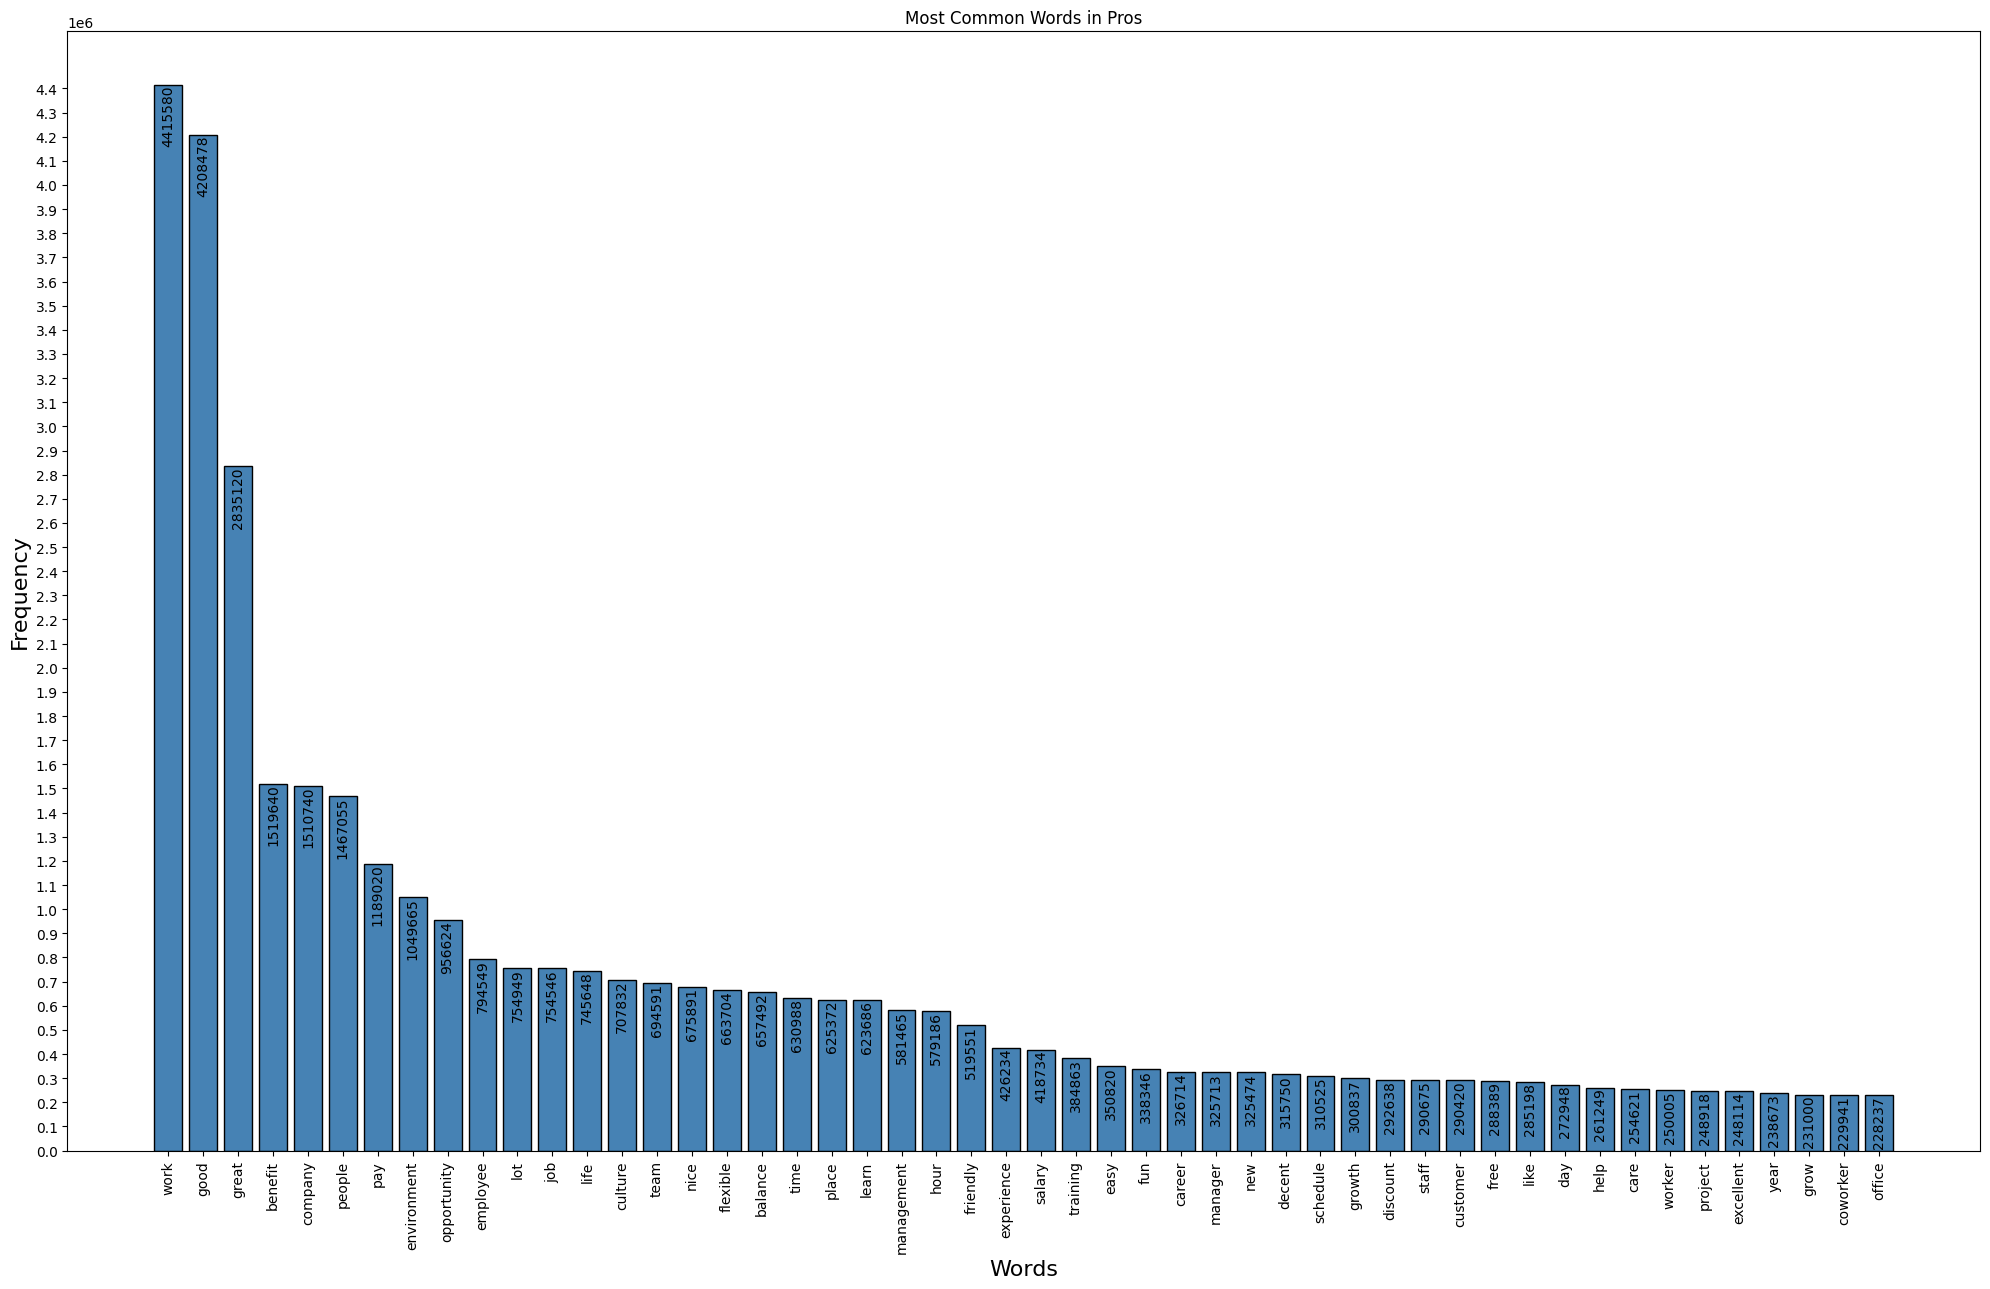

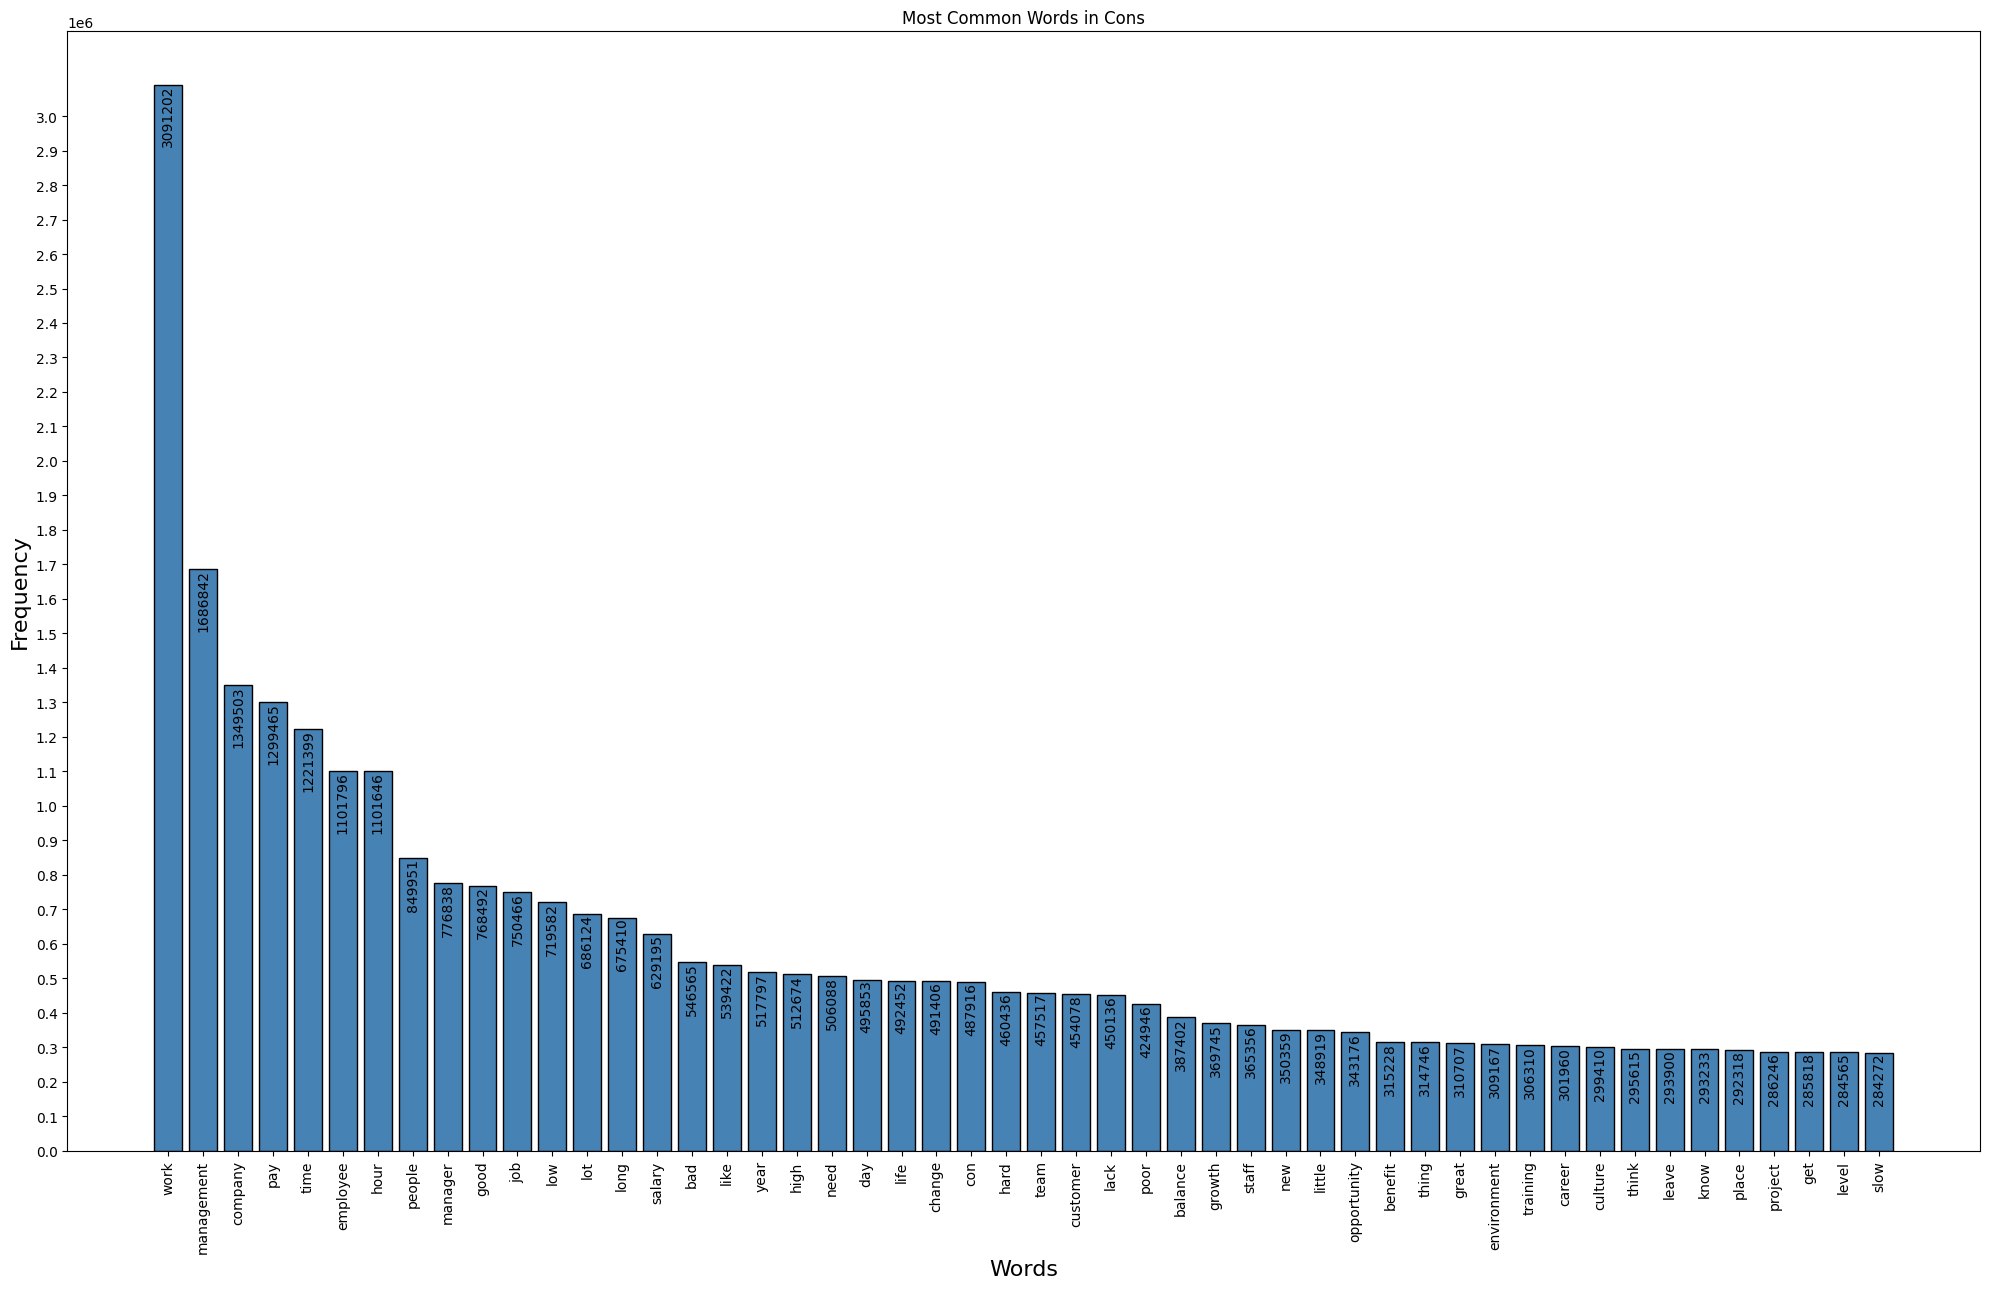

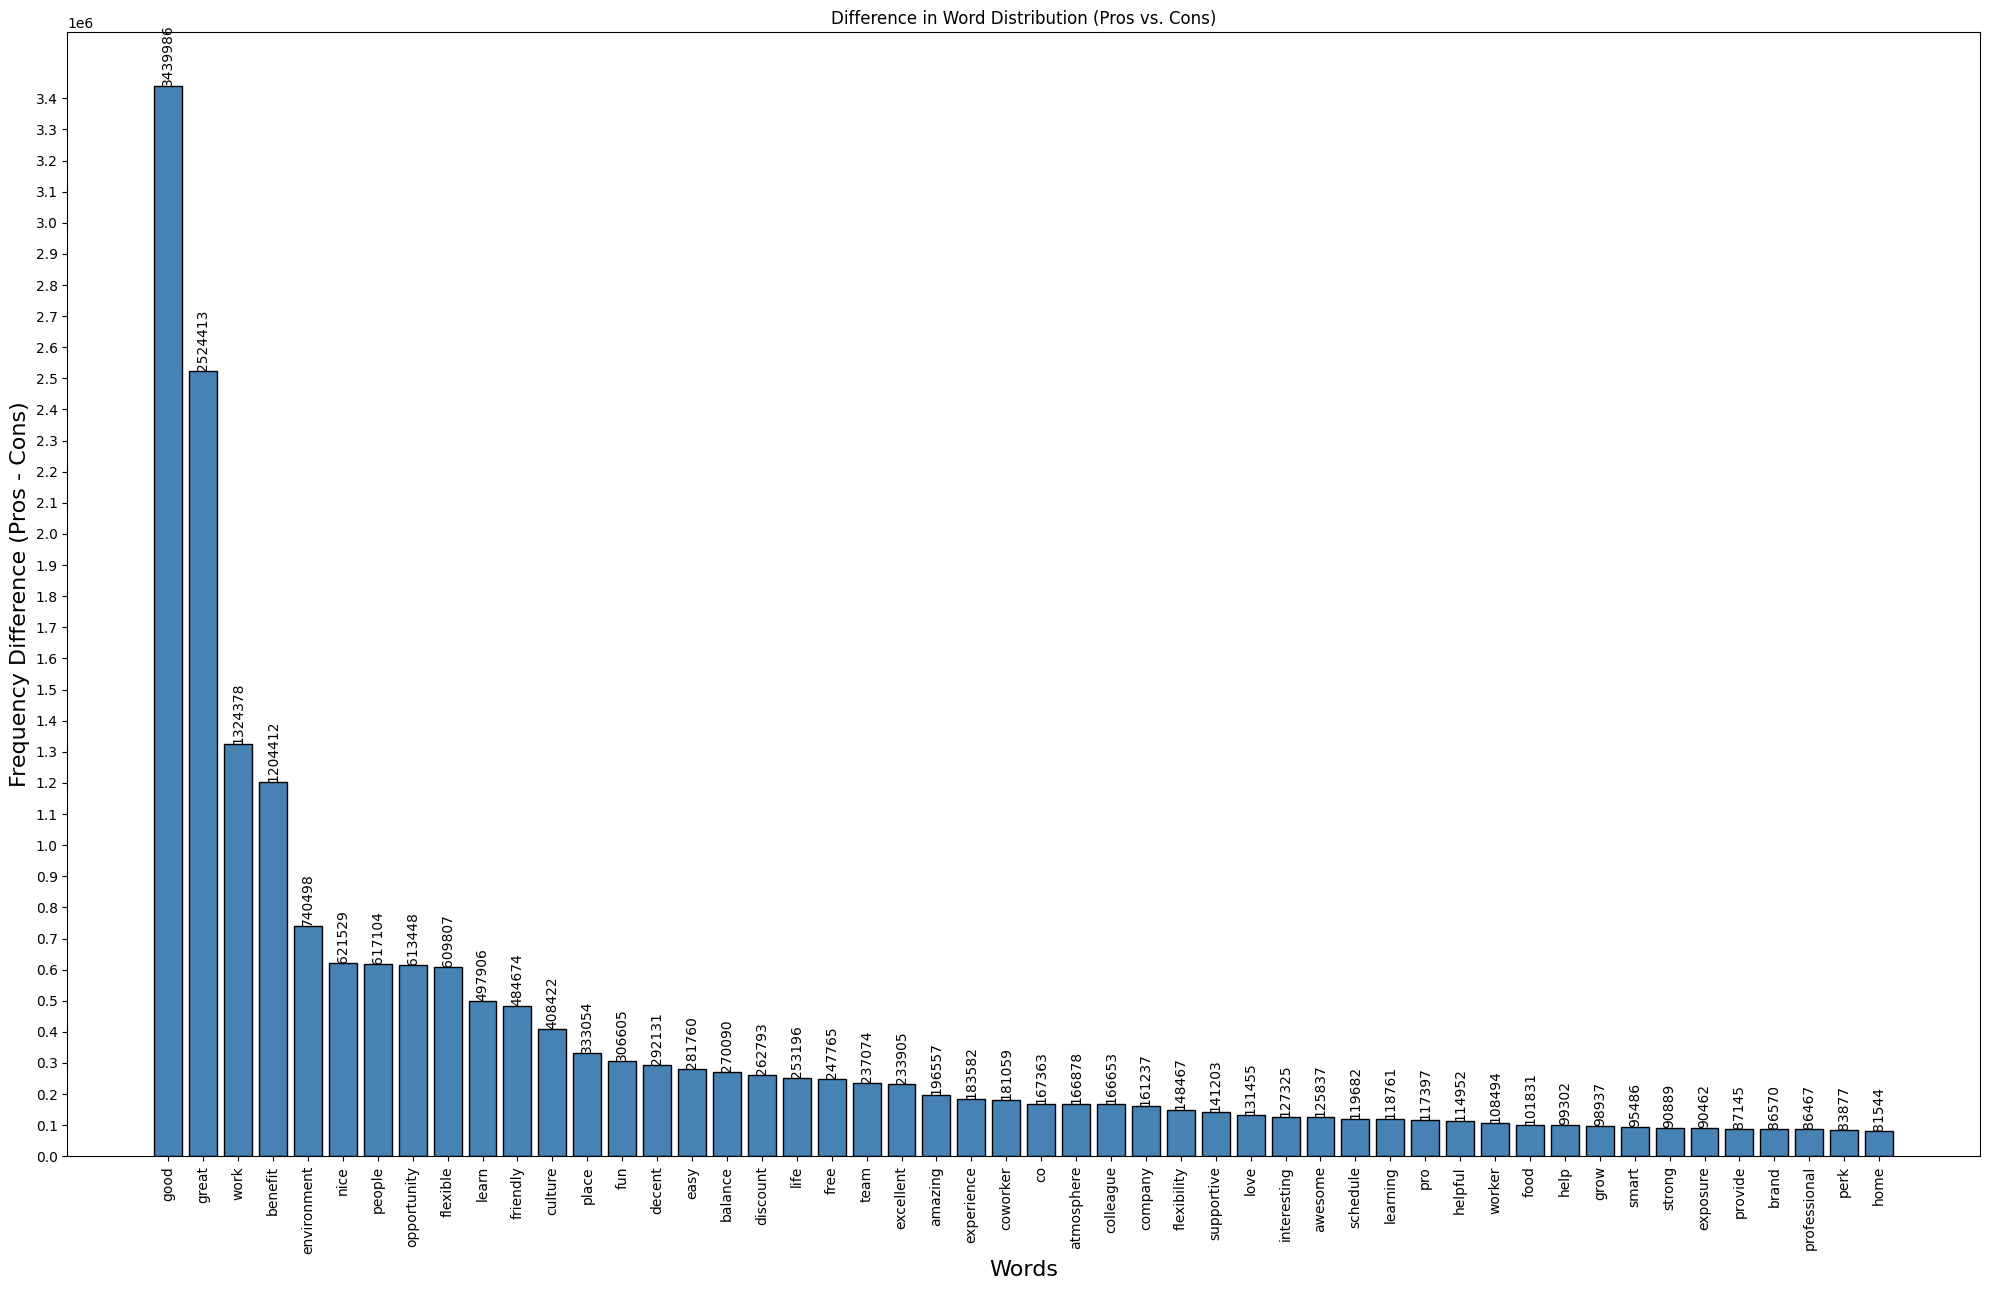

In [ ]:
# Getting all the words from our documents
all_words_pros = [word for sublist in df['pros_tokens'] for word in sublist]
all_words_cons = [word for sublist in df['cons_tokens'] for word in sublist]

word_freq_pros = {}
word_freq_cons = {}

# Getting word frequencies
for word in all_words_pros:
    word_freq_pros[word] = word_freq_pros.get(word, 0) + 1

for word in all_words_cons:
    word_freq_cons[word] = word_freq_cons.get(word, 0) + 1

# Sort words by frequency
sorted_words_pros = sorted(word_freq_pros.items(), key=lambda x: x[1], reverse=True)
sorted_words_cons = sorted(word_freq_cons.items(), key=lambda x: x[1], reverse=True)


# Take the difference between the two frequencies
word_freq_diff = {}
for word, freq in word_freq_pros.items():
    if word in word_freq_cons:
        word_freq_diff[word] = freq - word_freq_cons[word]

sorted_words_diff = sorted(word_freq_diff.items(), key=lambda item: item[1], reverse=True)



# Plotting most common words for pros
plt.figure(figsize=(20, 13))

words = [word for word, _ in sorted_words_pros[:50]]
counts = [count for _, count in sorted_words_pros[:50]]

bars = plt.bar(words, counts, color='steelblue', edgecolor='black')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='top', rotation=90)

plt.xlabel('Words', fontsize=16)
plt.xticks(rotation=90, ha='center')

plt.ylabel('Frequency', fontsize=16)
# Changing yticks to not show scientific notation
plt.yticks(range(0, max(counts)+1, 100000))

plt.title('Most Common Words in Pros')
plt.tight_layout()
plt.show()



# Plotting most common words for cons
plt.figure(figsize=(20, 13))

words = [word for word, _ in sorted_words_cons[:50]]
counts = [count for _, count in sorted_words_cons[:50]]

bars = plt.bar(words, counts, color='steelblue', edgecolor='black')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='top', rotation=90)

plt.xlabel('Words', fontsize=16)
plt.xticks(rotation=90, ha='center')

plt.ylabel('Frequency', fontsize=16)
plt.yticks(range(0, max(counts)+1, 100000))

plt.title('Most Common Words in Cons')
plt.tight_layout()
plt.show()



# Plotting most common words for diff
plt.figure(figsize=(20, 13))

words = [word for word, _ in sorted_words_diff[:50]]
counts = [count for _, count in sorted_words_diff[:50]]

bars = plt.bar(words, counts, color='steelblue', edgecolor='black')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', rotation=90)

plt.xlabel('Words', fontsize=16)
plt.xticks(rotation=90, ha='center')

plt.ylabel('Frequency Difference (Pros - Cons)', fontsize=16)
plt.yticks(range(0, max(counts)+1, 100000))

plt.title('Difference in Word Distribution (Pros vs. Cons)')
plt.tight_layout()
plt.show()

# Extraction of Topics with LDA

Rather than trying to extract topics across the entire dataset, I make heavy use of the various different data categories present in this dataset to create focused data subsets. These subsets let us view the extremes within the entire dataset, while still remaining general enough to be applicable to the whole population. In this way we will be able to reach conclusions in a more efficient manner, by reducing data dimensionality and reducing computational requirements, without sacrificing overall accuracy. Separating the datasets out into subsets also allows for both a per-basis analysis of results as well as a comparative analysis.

I make heavy use of the Gensim package in order to efficiently create LDA models. pyLDAvis is used in order to create interpretable visualizations alongside the computed coherence scores. The use of more advanced models, like BERTopic, were considered for this section. However, those models proved to largely be "black-box" models with little interpretability as to what was happening within the model itself. For the purpose of pursuing a more explainable model, I opted to stay with an LDA model.

The end result is a series of interactive Intertopic Distance Maps. The first graph shows the distance between topic distributions, which are taken from LDA models that were trained on an optimal number of topics. The bar chart compares term saliency within a topic, how often a particular term is mentioned within the filtered corpus for that particular topic, versus the the term relevance towards the topic itself. This comparison can be adjusted via the slider which changes the lambda value. The higher the lambda value chosen, the more relevant the term will be to the topic distribution. In this way we have the option for further analysis of the topic results.

## Taking Reduced Samples From Dataset

Since we are particularly interested in figuring out what makes for good leadership, we take samples from the dataset

In [ ]:
# taking a 100000 sample of pros filtered for a ratings of 5
df_pros5_sample = df[df['rating'] == 5].sample(n=100000, random_state=42)

# taking a 100000 sample of cons filtered for a rating of 1
df_cons1_sample = df[df['rating'] == 1].sample(n=100000, random_state=42)

# taking a 100000 sample of various ceo approval classifications
df_ceo_approval_pos_sample = df[(df['CEO Approval_Positive'] == 1)].sample(n=100000, random_state=42)
df_ceo_approval_neg_sample = df[(df['CEO Approval_Negative'] == 1)].sample(n=100000, random_state=42)
df_ceo_approval_mild_sample = df[(df['CEO Approval_Mild'] == 1)].sample(n=100000, random_state=42)

# Taking a 100000 sample of various senior management ratings
df_sm5_sample = df[(df['Senior Management'] == 5)].sample(n=100000, random_state=42)
df_sm3_sample = df[(df['Senior Management'] == 3)].sample(n=100000, random_state=42)
df_sm1_sample = df[(df['Senior Management'] == 1)].sample(n=100000, random_state=42)

# Getting a general sample to be used later
df_sample = df.sample(n=100000, random_state=42)

## Function for LDA Modeling

In [ ]:
!pip install pyLDAvis --quiet
import pyLDAvis
import pyLDAvis.gensim_models

import logging
# Set the logging level to suppress specific warnings
logging.getLogger('gensim').setLevel(logging.ERROR)

def compute_coherence_values(corpus, dictionary, k, texts):
    coherence_values = []
    model_list = []
    for num_topics in range(2, k):
        # Model gets trained on initialization
        model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=42,
                         per_word_topics=True)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        model_list.append(model)
    return model_list, coherence_values

def prepare_lda_model(df, column_name, graph_name):
    print(f'MODELING LDA TOPICS FOR: {graph_name}')
    # Casting the tokenized column to list in order to use the gensim LDA
    texts = df[column_name].tolist()

    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    # Compute the coherence score
    model_list, coherence_values = compute_coherence_values(corpus=corpus, dictionary=dictionary, k=15, texts=texts)

    # Show graph
    plt.figure(figsize=(10, 6))
    limit=15; start=2; step=1;
    x = range(start, limit)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.title(f"Coherence Score vs. Num Topics for {graph_name}")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

    best_result_index = coherence_values.index(max(coherence_values))
    optimal_model = model_list[best_result_index]
    print(f"Optimal Model: {optimal_model}")

    # Creating topic distance visualization
    pyLDAvis.enable_notebook()
    vis_data = pyLDAvis.gensim_models.prepare(optimal_model, corpus, dictionary)

    # Save the visualization as an unique HTML file
    # pyLDAvis.save_html(vis_data, 'lda_vis.html')
    pyLDAvis.save_html(vis_data, f'{graph_name}_vis.html')

    # Display the result
    # print(f'\nLDA Intertopic Visualization for {graph_name}')
    # display(HTML('lda_vis.html'))
    print('\n\n')

    return optimal_model, coherence_values

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


MODELING LDA TOPICS FOR: Senior Management Pros Rated 1


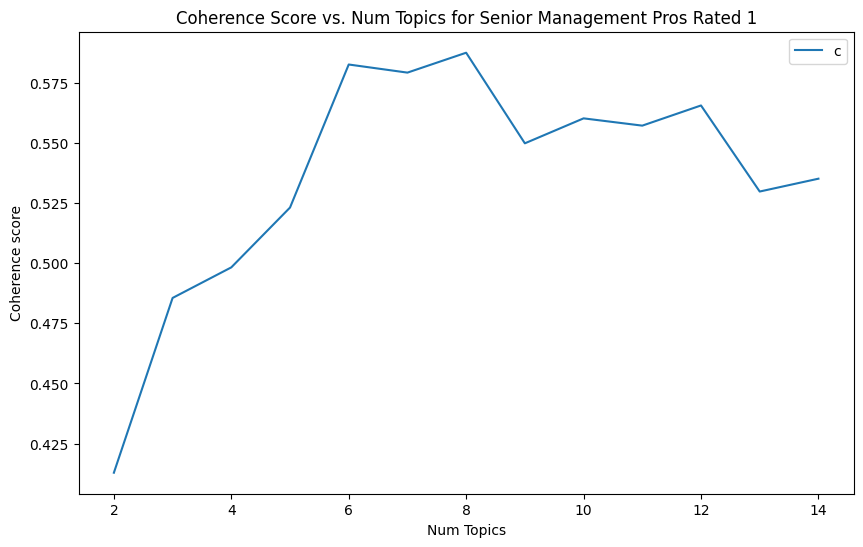

Optimal Model: LdaModel<num_terms=22239, num_topics=8, decay=0.5, chunksize=2000>



MODELING LDA TOPICS FOR: Senior Management Pros Rated 5


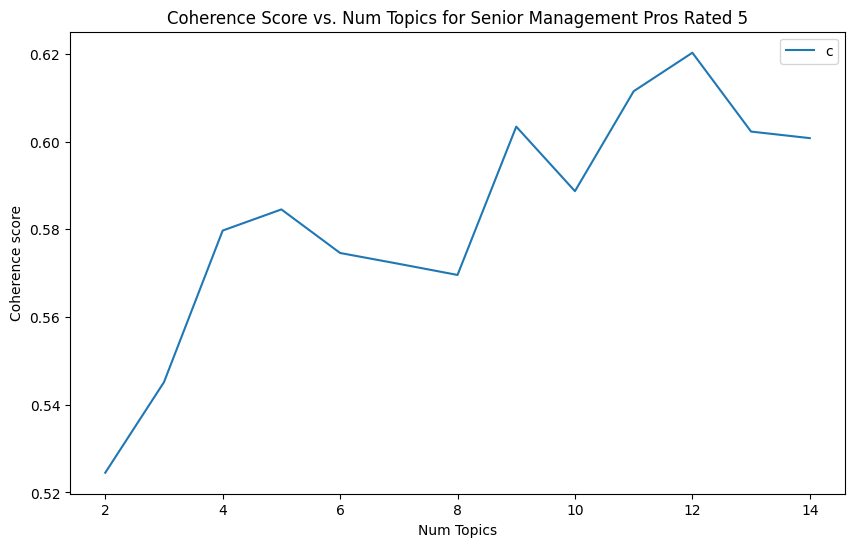

Optimal Model: LdaModel<num_terms=23695, num_topics=12, decay=0.5, chunksize=2000>





In [ ]:
sm1_pros_lda_model, sm1_pros_coherence = prepare_lda_model(df_sm1_sample, 'pros_tokens', 'Senior Management Pros Rated 1')
sm5_pros_lda_model, sm5_pros_coherence = prepare_lda_model(df_sm5_sample, 'pros_tokens', 'Senior Management Pros Rated 5')

In [ ]:
# Display the result the pyLDAvis results
print(f'LDA Intertopic Visualization for Senior Management Pros Rated 1')
display(HTML('Senior Management Pros Rated 1_vis.html'))
print('\n\n')

print(f'LDA Intertopic Visualization for Senior Management Pros Rated 5')
display(HTML('Senior Management Pros Rated 5_vis.html'))
print('\n\n')

LDA Intertopic Visualization for Senior Management Pros Rated 1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)





LDA Intertopic Visualization for Senior Management Pros Rated 5


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


MODELING LDA TOPICS FOR: Senior Management Cons Rated 1


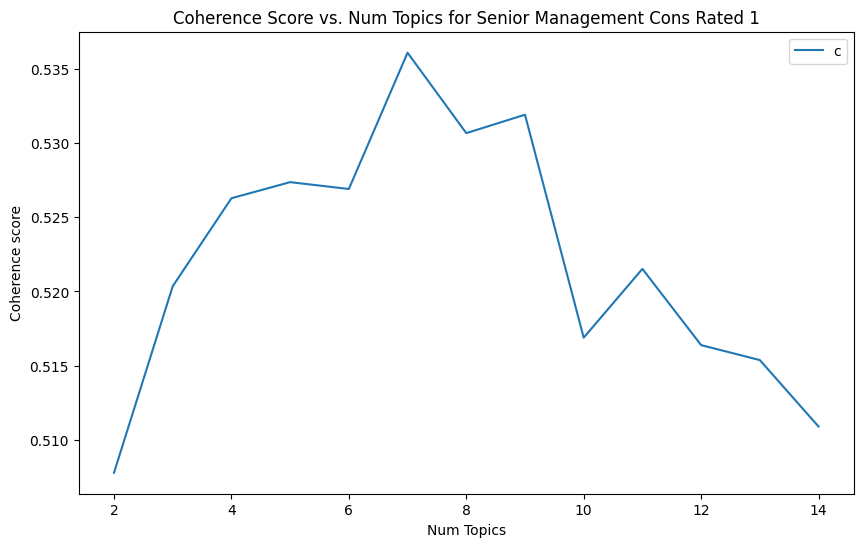

Optimal Model: LdaModel<num_terms=44117, num_topics=7, decay=0.5, chunksize=2000>



MODELING LDA TOPICS FOR: Senior Management Cons Rated 5


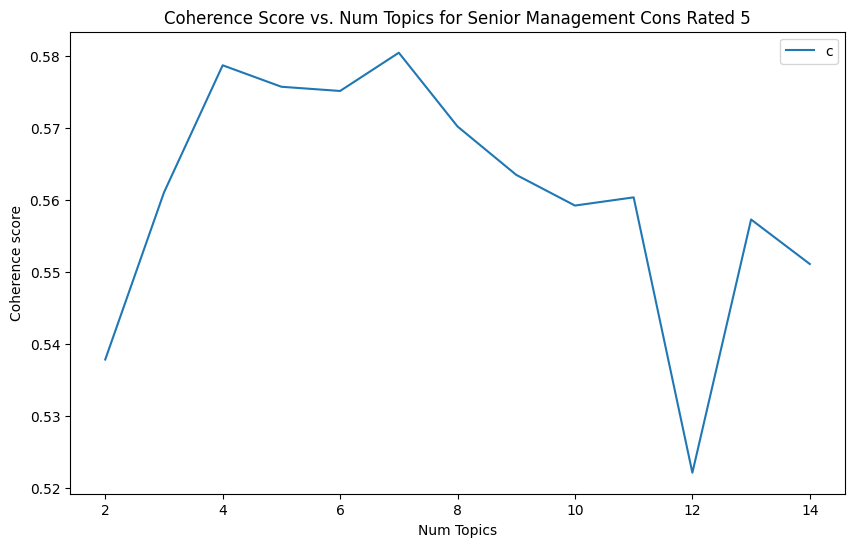

Optimal Model: LdaModel<num_terms=21147, num_topics=7, decay=0.5, chunksize=2000>





In [ ]:
sm1_cons_lda_model, sm1_cons_coherence = prepare_lda_model(df_sm1_sample, 'cons_tokens', 'Senior Management Cons Rated 1')
sm5_cons_lda_model, sm5_cons_coherence = prepare_lda_model(df_sm5_sample, 'cons_tokens', 'Senior Management Cons Rated 5')

In [ ]:
# Display the result the pyLDAvis results
print(f'LDA Intertopic Visualization for Senior Management Cons Rated 1')
display(HTML('Senior Management Cons Rated 1_vis.html'))
print('\n\n')

print(f'LDA Intertopic Visualization for Senior Management Cons Rated 5')
display(HTML('Senior Management Cons Rated 5_vis.html'))
print('\n\n')

LDA Intertopic Visualization for Senior Management Cons Rated 1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)





LDA Intertopic Visualization for Senior Management Cons Rated 5


MODELING LDA TOPICS FOR: CEO Approval Pros Positive


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


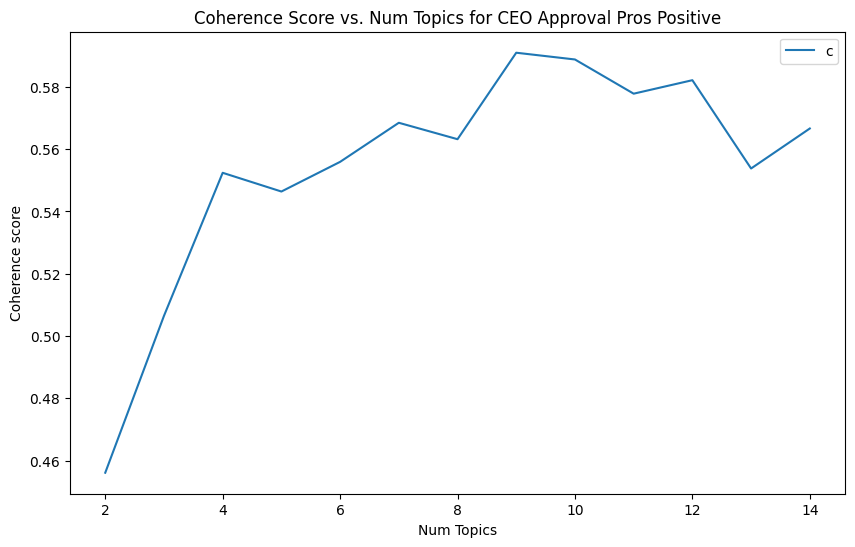

Optimal Model: LdaModel<num_terms=22942, num_topics=9, decay=0.5, chunksize=2000>



MODELING LDA TOPICS FOR: CEO Approval Pros Negative


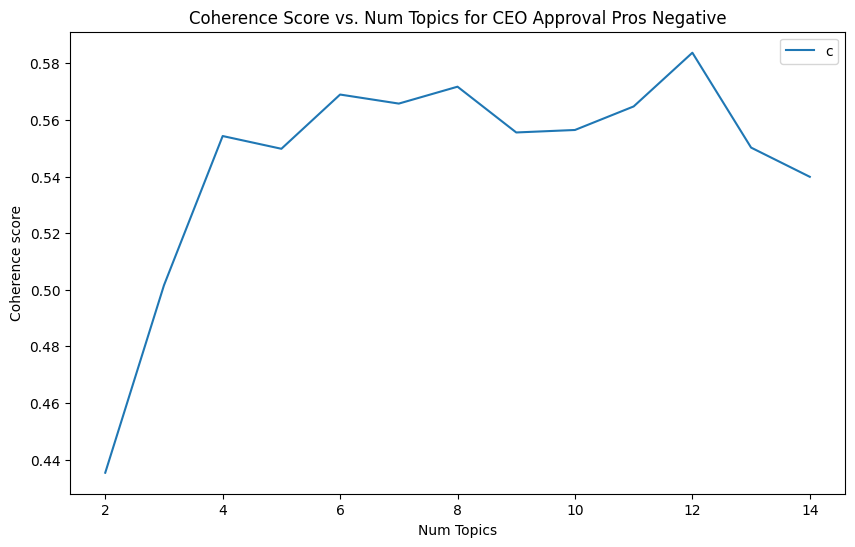

Optimal Model: LdaModel<num_terms=22829, num_topics=12, decay=0.5, chunksize=2000>





In [ ]:
ceo_pos_pros_lda_model, ceo_pos_pros_coherence = prepare_lda_model(df_ceo_approval_pos_sample, 'pros_tokens', 'CEO Approval Pros Positive')
ceo_neg_pros_lda_model, ceo_neg_pros_coherence = prepare_lda_model(df_ceo_approval_neg_sample, 'pros_tokens', 'CEO Approval Pros Negative')

In [ ]:
# Display the result the pyLDAvis results
print(f'LDA Intertopic Visualization for CEO Approval Pros Positive')
display(HTML('CEO Approval Pros Positive_vis.html'))
print('\n\n')

print(f'LDA Intertopic Visualization for CEO Approval Pros Negative')
display(HTML('CEO Approval Pros Negative_vis.html'))
print('\n\n')

LDA Intertopic Visualization for CEO Approval Pros Positive


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)





LDA Intertopic Visualization for CEO Approval Pros Negative


MODELING LDA TOPICS FOR: Cons Rating 1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


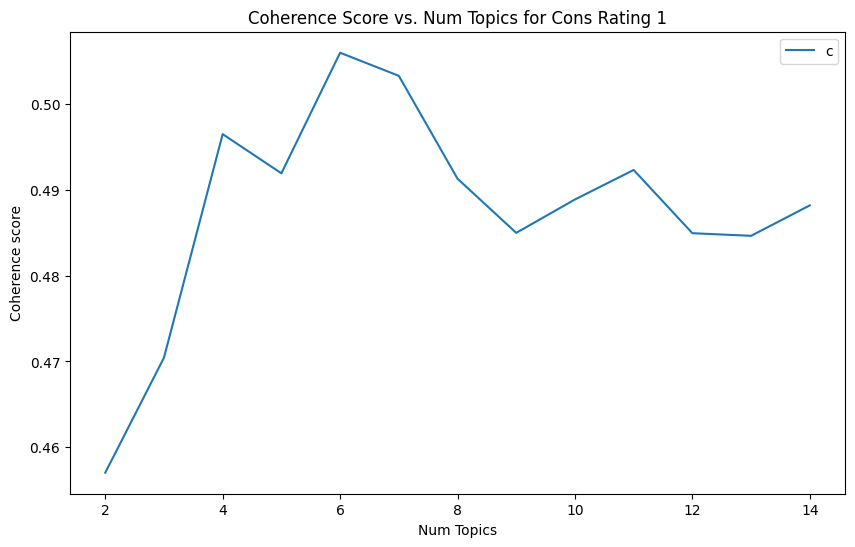

Optimal Model: LdaModel<num_terms=48549, num_topics=6, decay=0.5, chunksize=2000>



MODELING LDA TOPICS FOR: Pros Rating 5


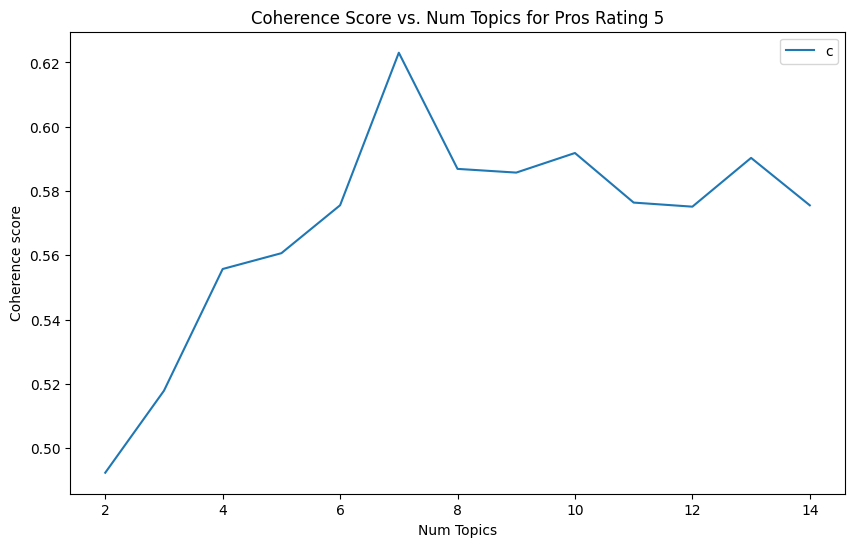

Optimal Model: LdaModel<num_terms=21833, num_topics=7, decay=0.5, chunksize=2000>





In [ ]:
cons1_lda_model, cons1_coherence = prepare_lda_model(df_cons1_sample, 'cons_tokens', 'Cons Rating 1')
pros5_lda_model, pros5_coherence = prepare_lda_model(df_pros5_sample, 'pros_tokens', 'Pros Rating 5')

In [ ]:
# Display the result the pyLDAvis results
print(f'LDA Intertopic Visualization for Cons Rating 1')
display(HTML('Cons Rating 1_vis.html'))
print('\n\n')

print(f'LDA Intertopic Visualization for Pros Rating 5')
display(HTML('Pros Rating 5_vis.html'))
print('\n\n')

LDA Intertopic Visualization for Cons Rating 1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)





LDA Intertopic Visualization for Pros Rating 5


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


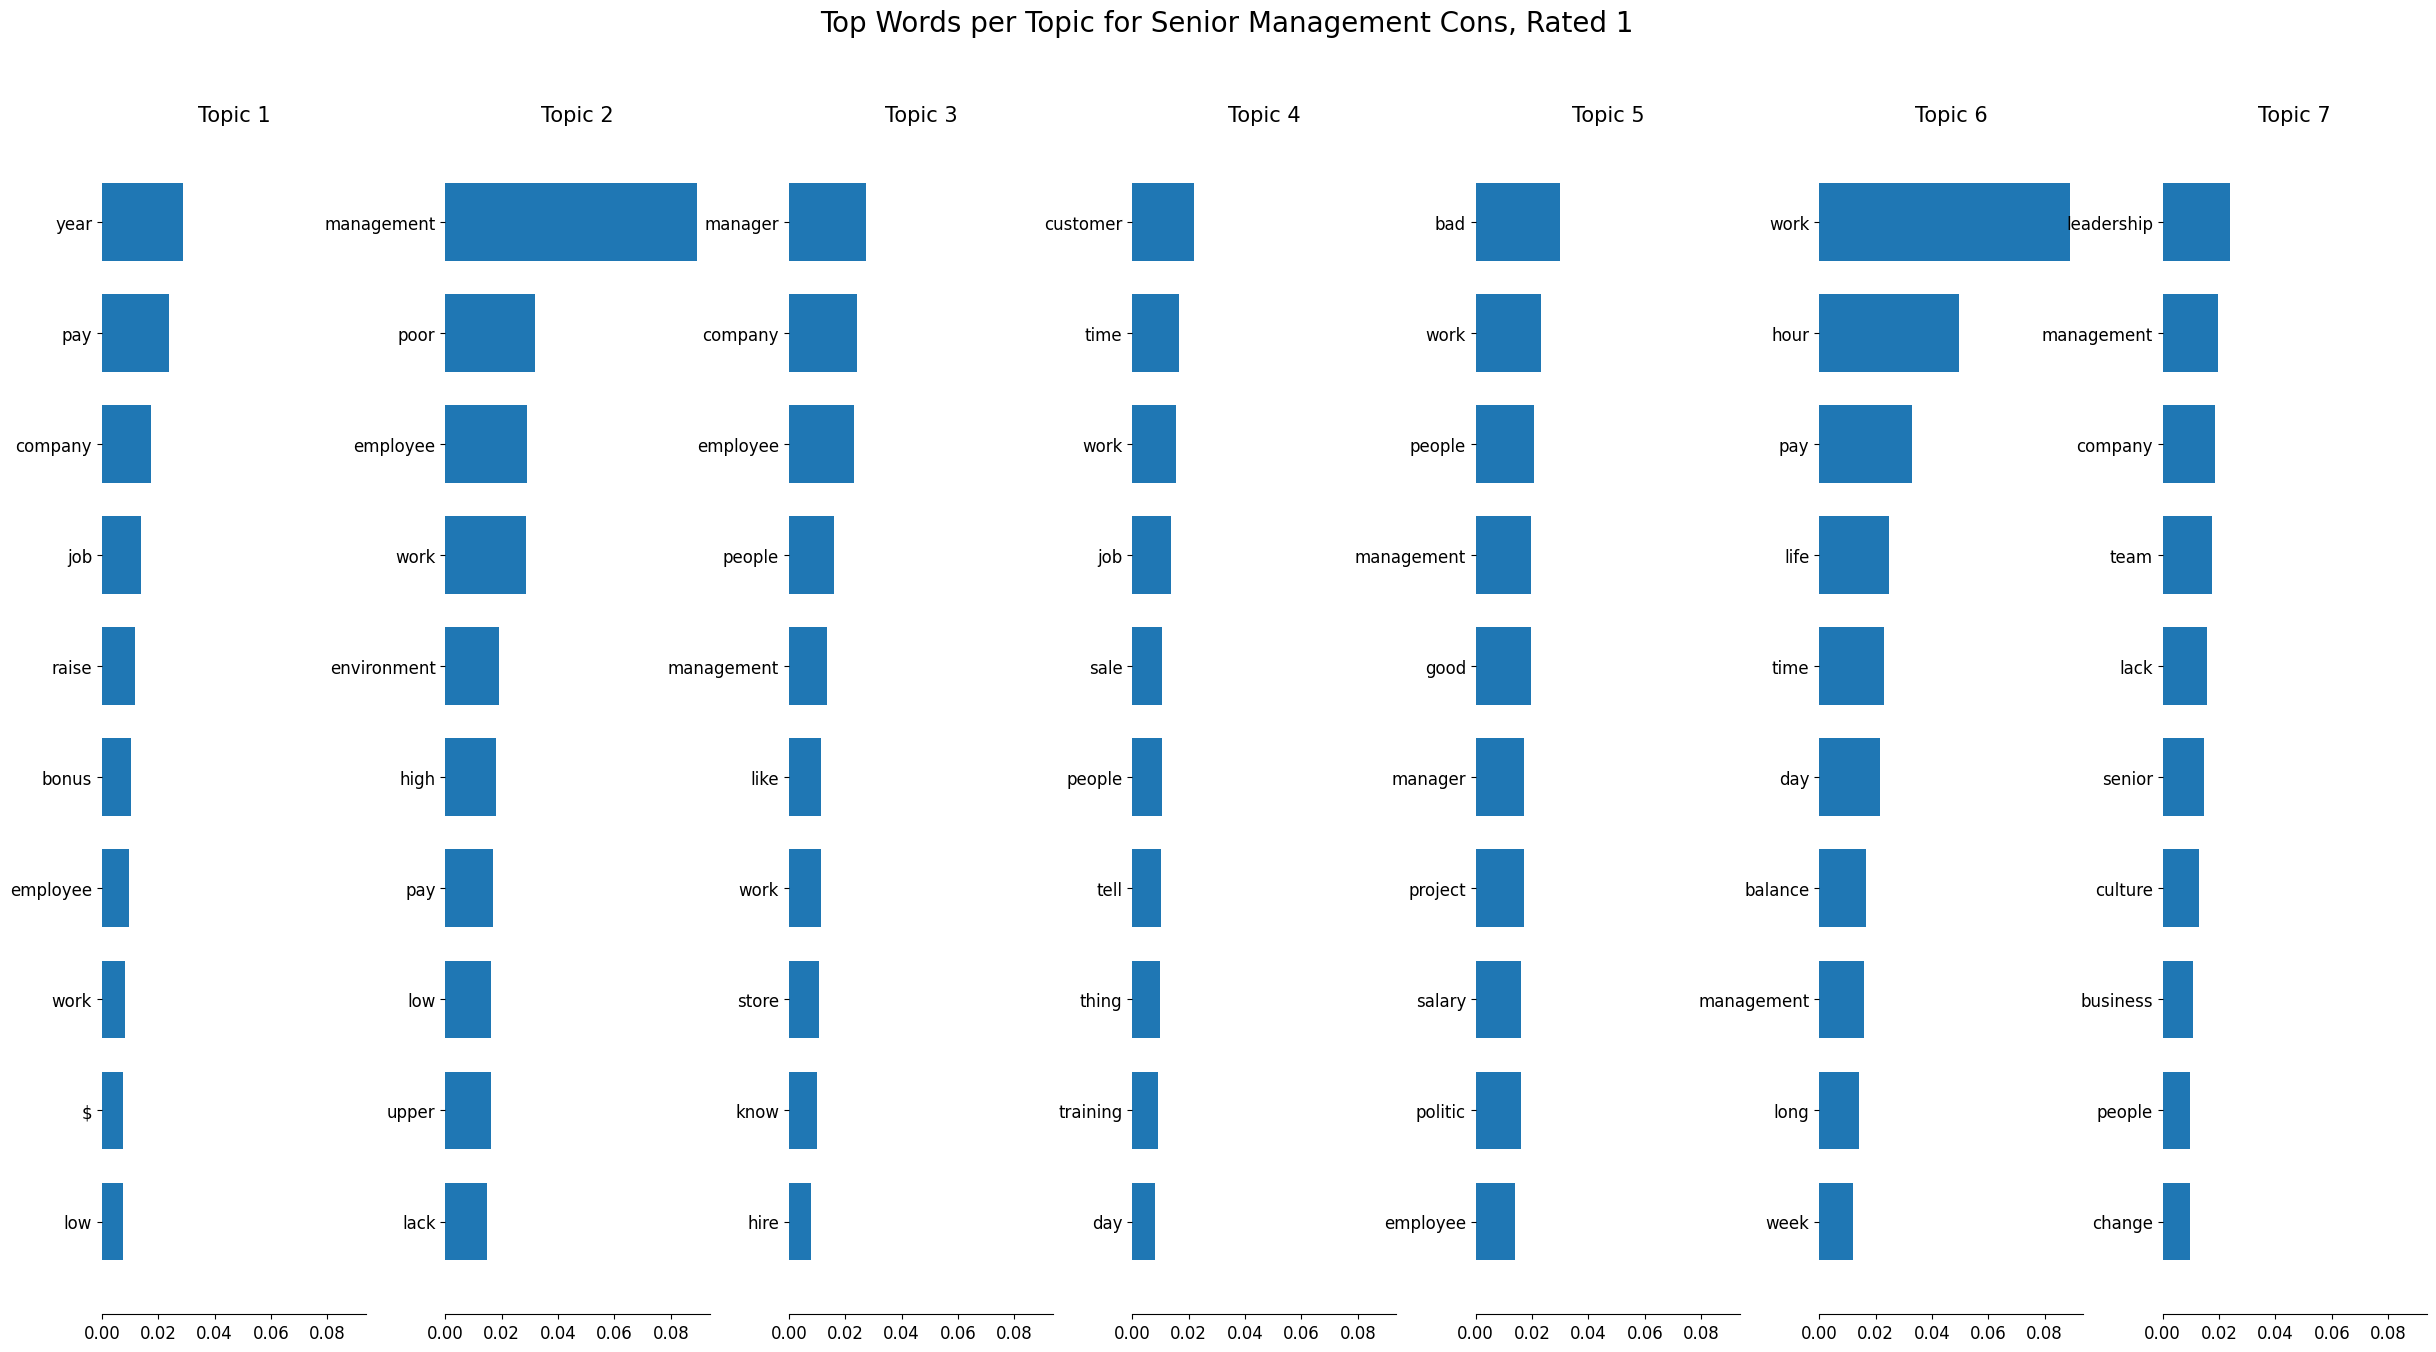

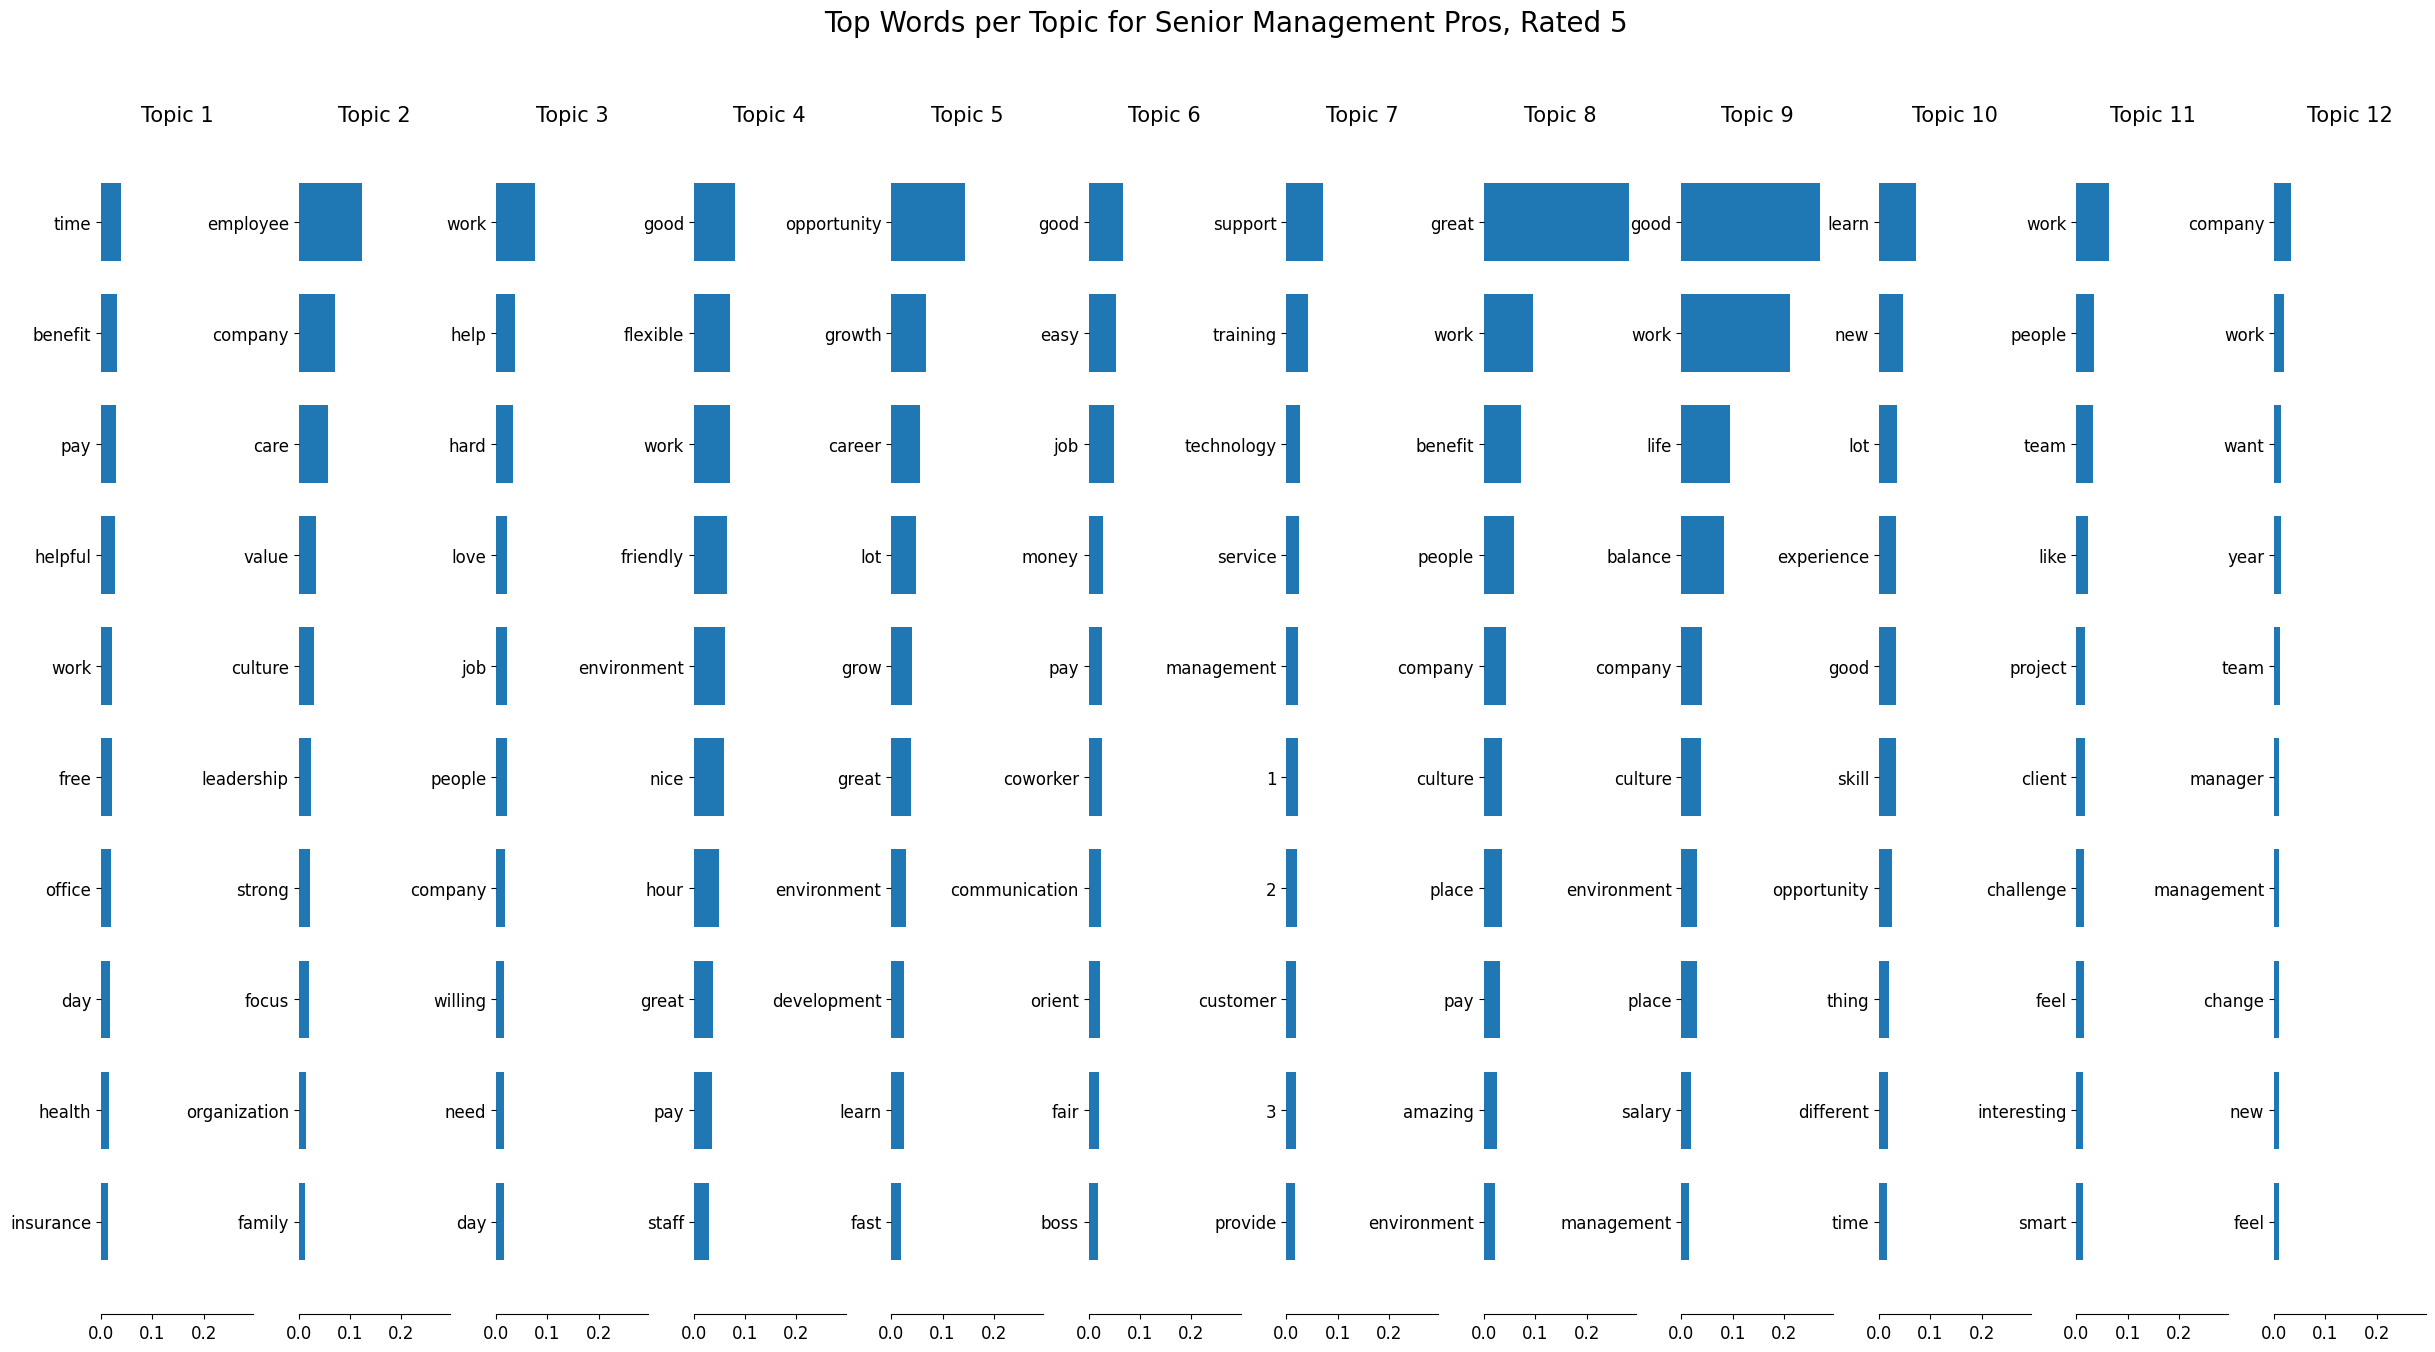

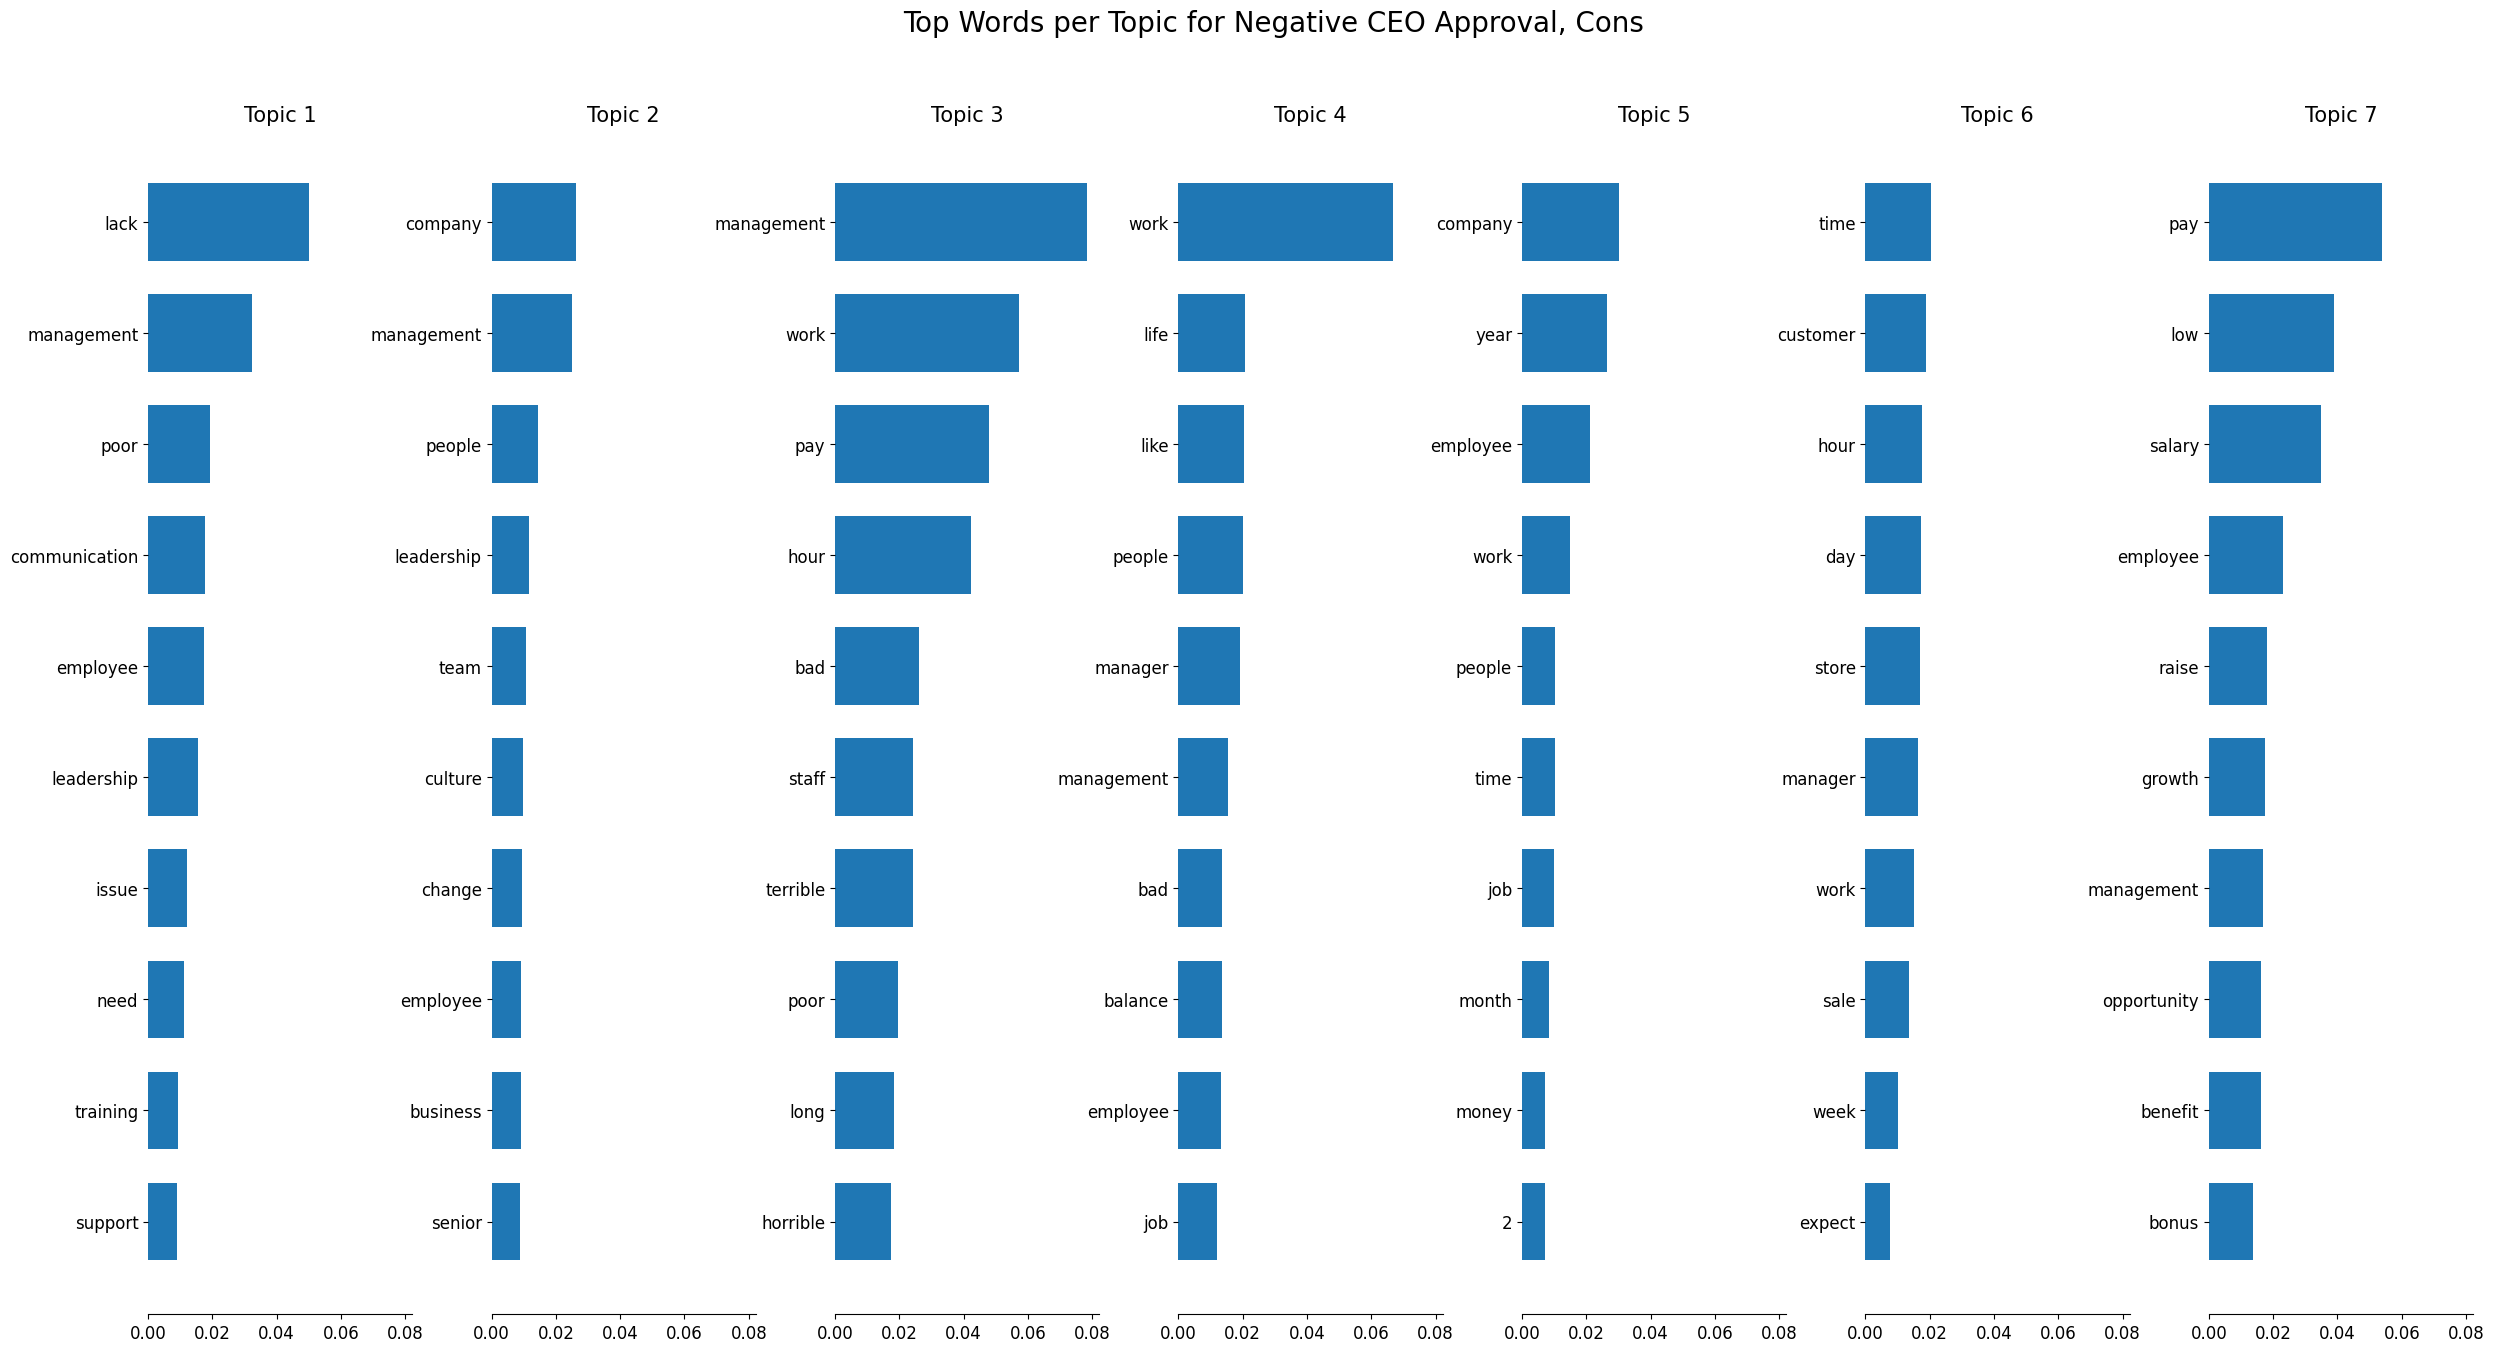

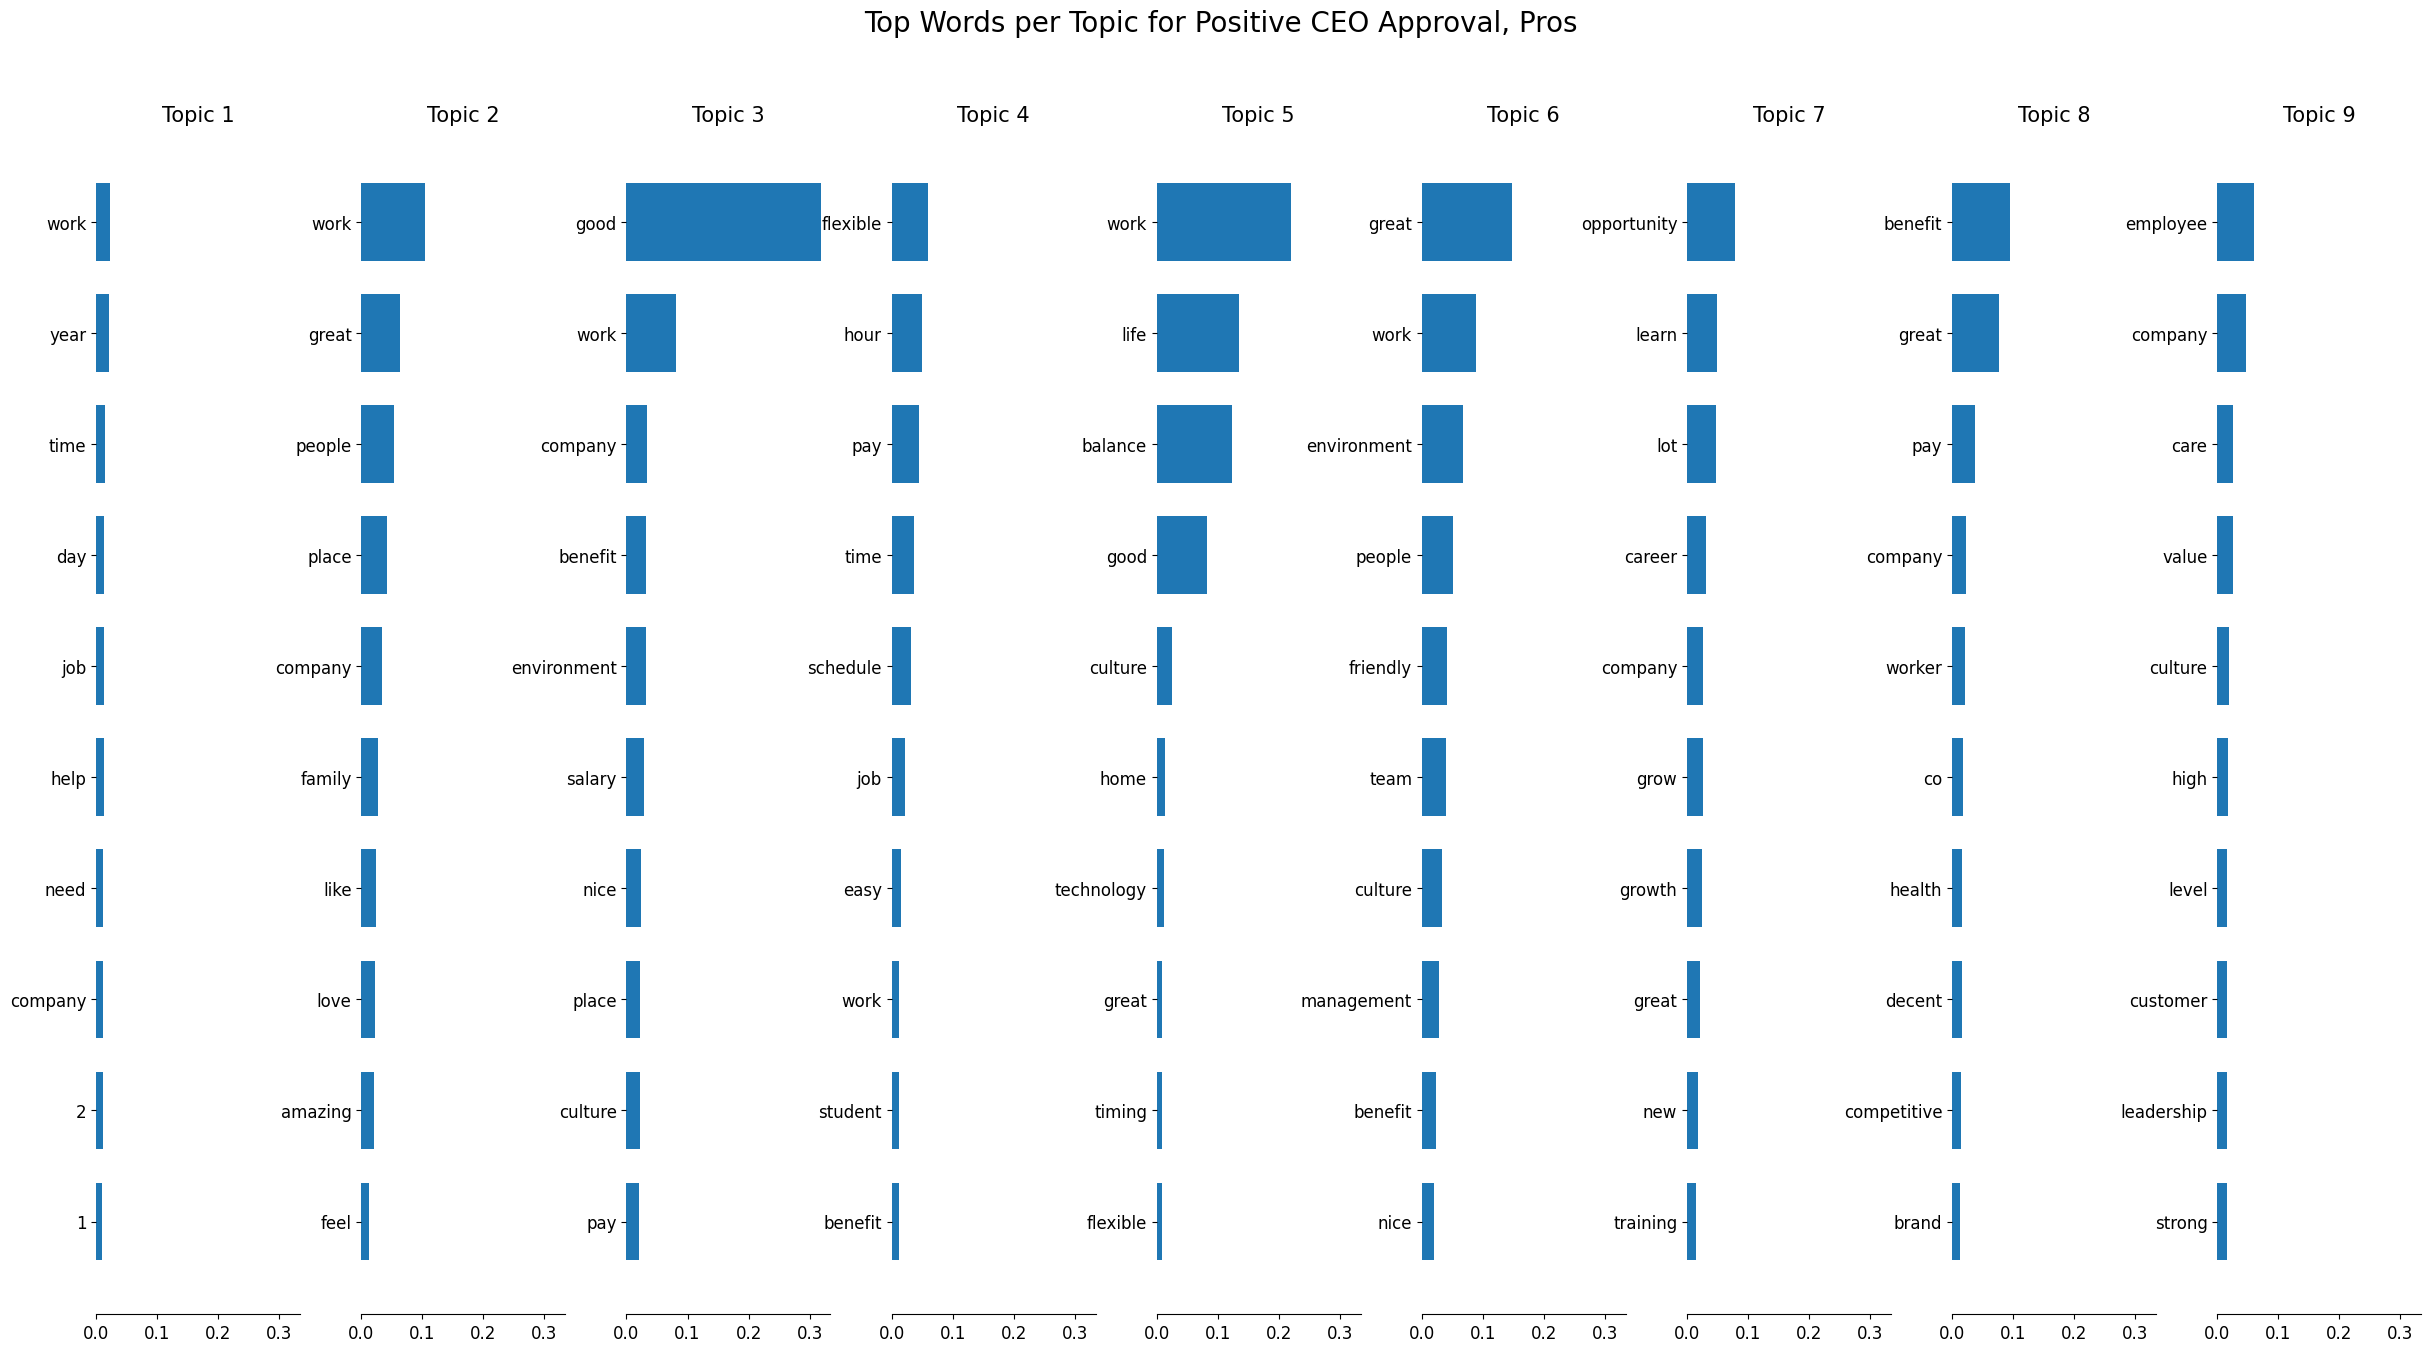

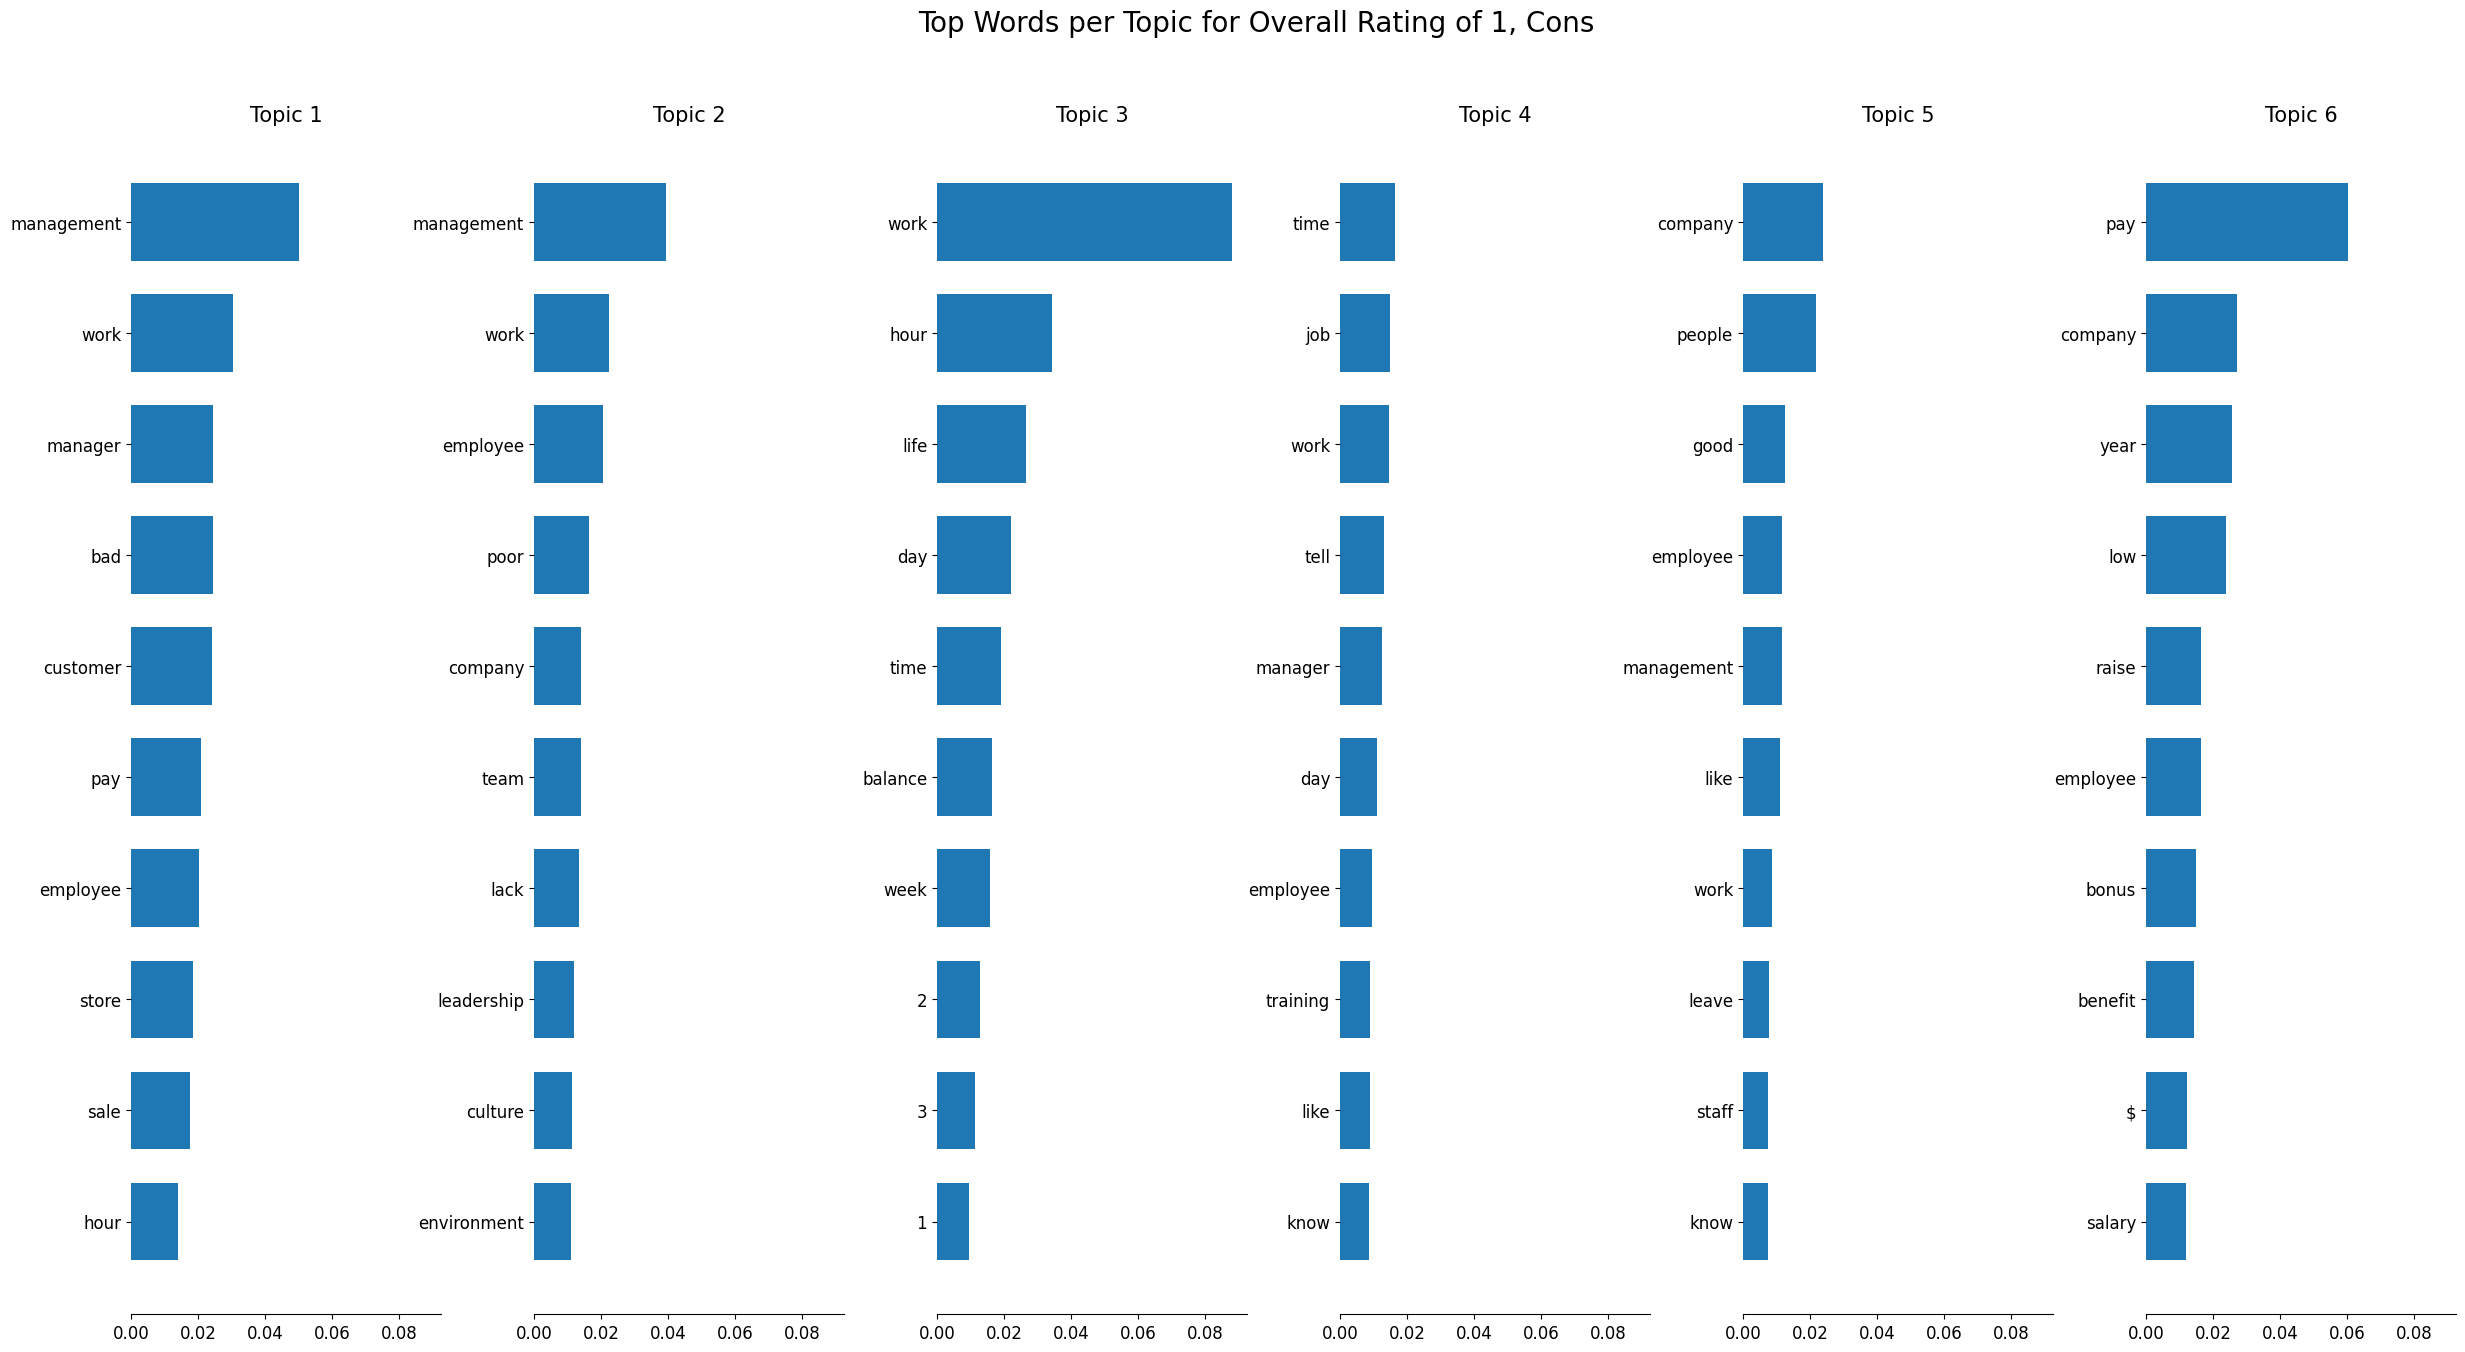

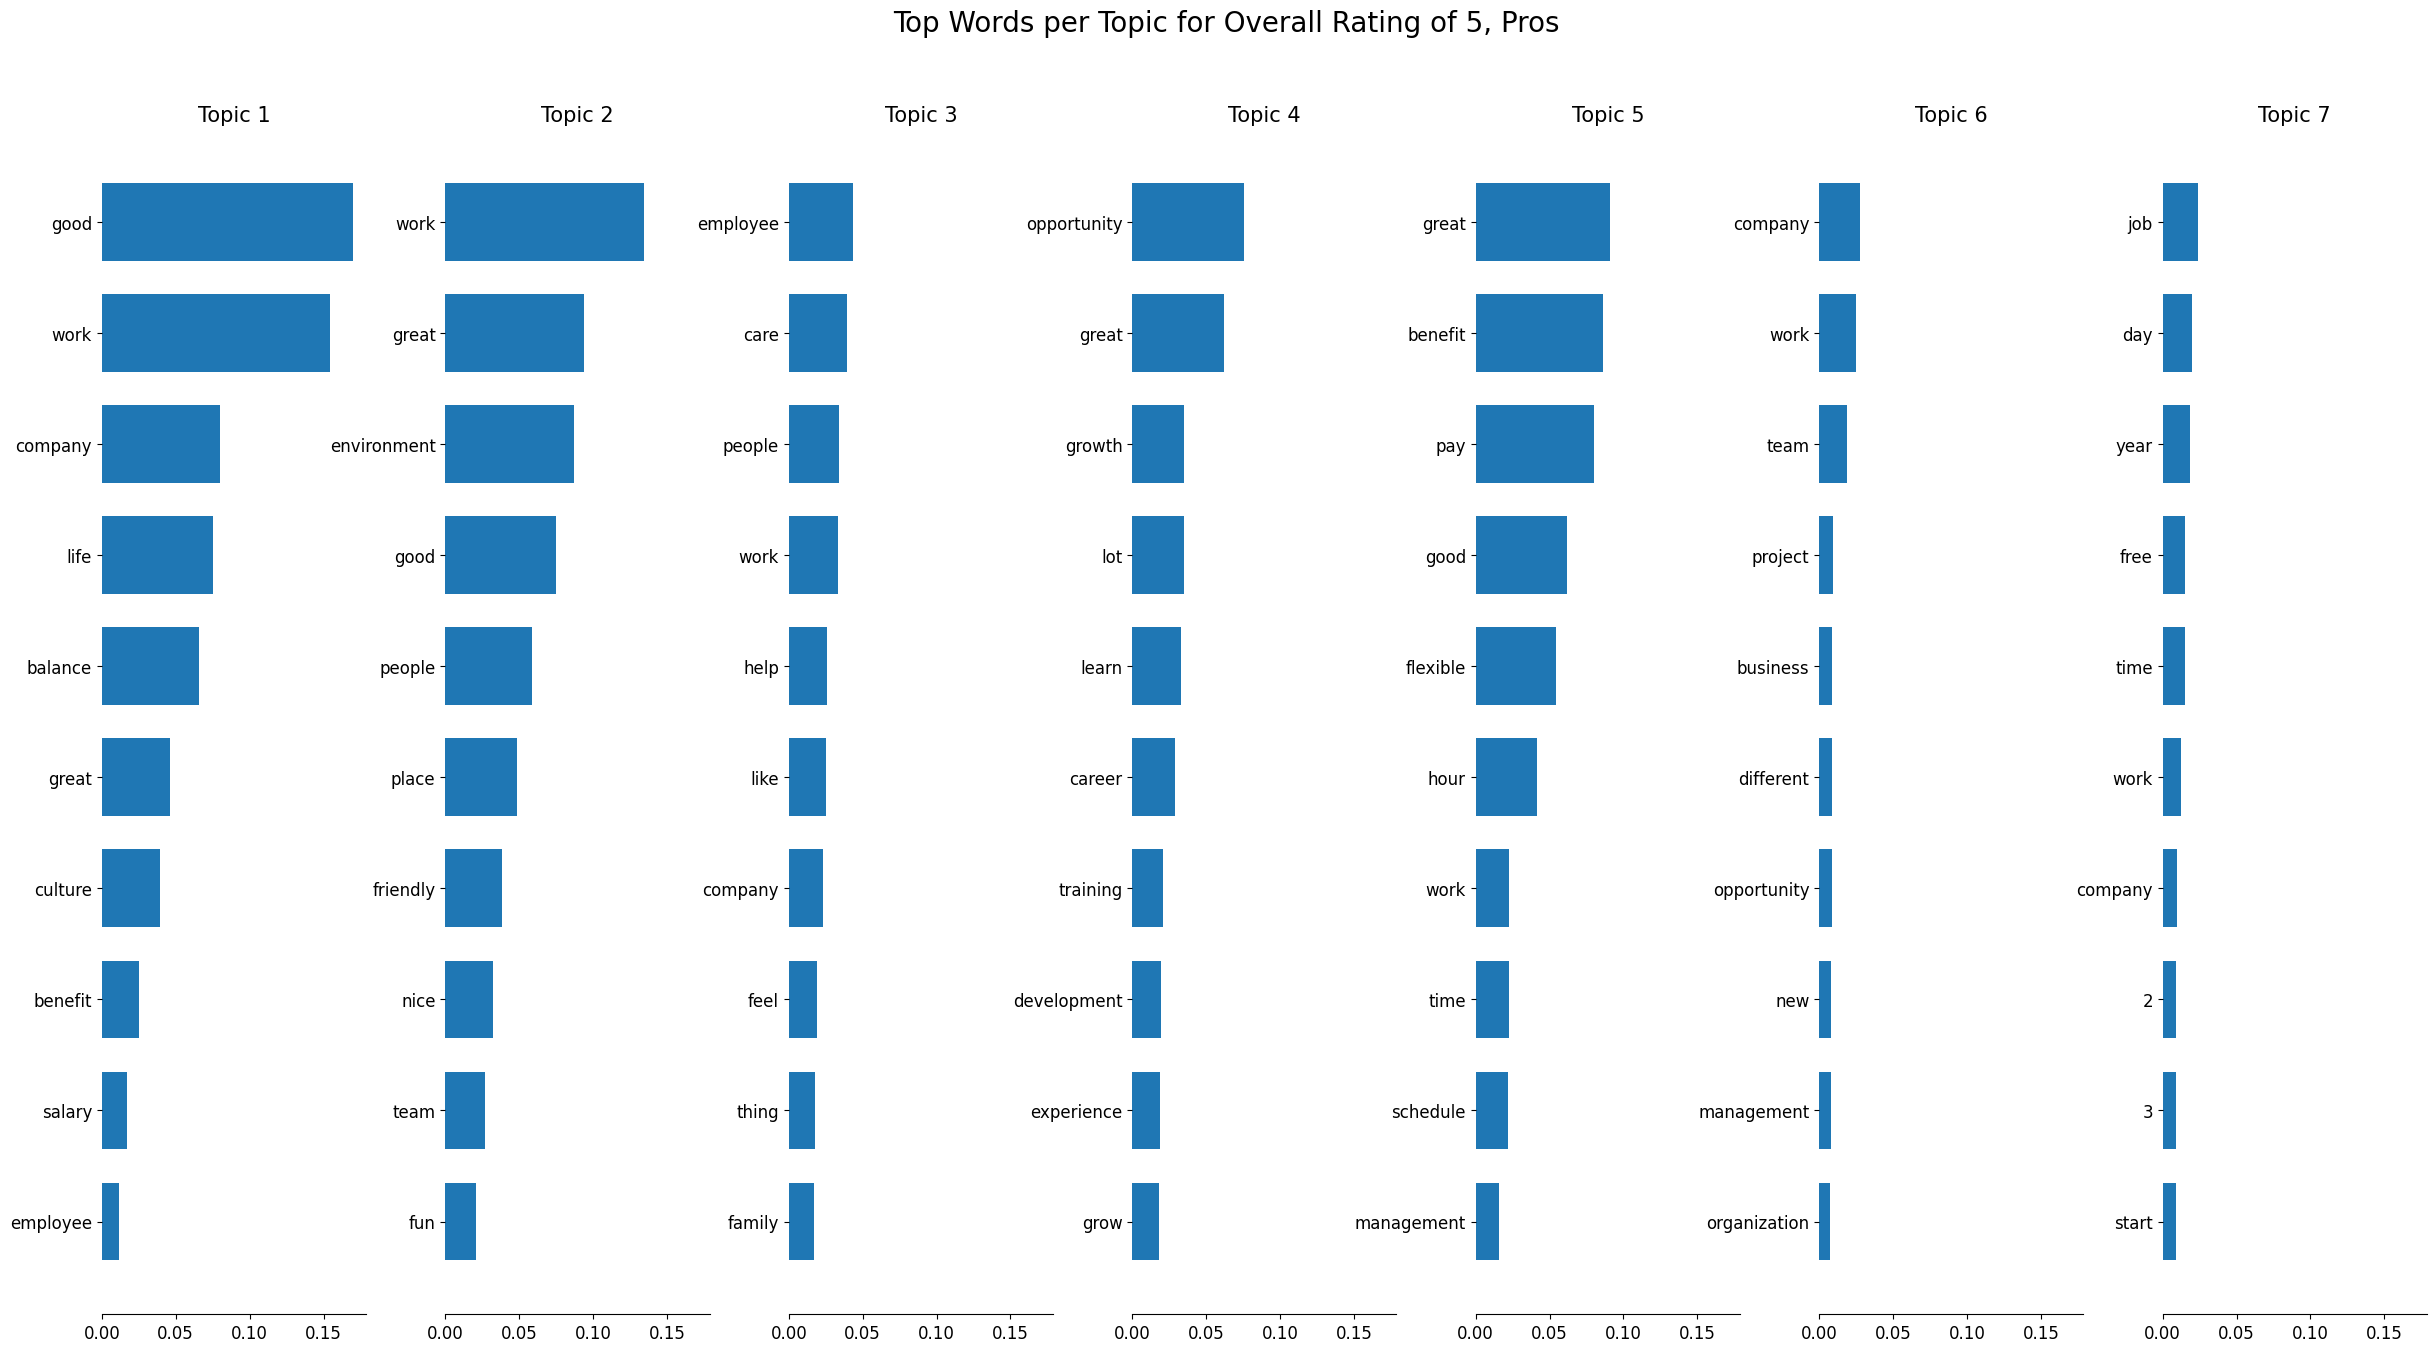

In [ ]:
def plot_top_words(lda_model, num_words, title):
    num_topics = lda_model.num_topics
    fig, axes = plt.subplots(1, num_topics, figsize=(30, 15), sharex=True)
    axes = axes.flatten()

    for topic_idx in range(num_topics):
        topic_terms = lda_model.show_topic(topic_idx, num_words)
        top_features = [term for term, prob in topic_terms]
        weights = [prob for term, prob in topic_terms]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx + 1}', fontdict={'fontsize': 15})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)

    fig.suptitle(title, fontsize=20)
    plt.subplots_adjust(top=0.90, wspace=0.3)
    plt.show()

# Plotting top words for each topic in the best LDA model
plot_top_words(sm1_cons_lda_model, 10, 'Top Words per Topic for Senior Management Cons, Rated 1')
plot_top_words(sm5_pros_lda_model, 10, 'Top Words per Topic for Senior Management Pros, Rated 5')
plot_top_words(ceo_neg_cons_lda_model, 10, 'Top Words per Topic for Negative CEO Approval, Cons')
plot_top_words(ceo_pos_pros_lda_model, 10, 'Top Words per Topic for Positive CEO Approval, Pros')
plot_top_words(cons1_lda_model, 10, 'Top Words per Topic for Overall Rating of 1, Cons')
plot_top_words(pros5_lda_model, 10, 'Top Words per Topic for Overall Rating of 5, Pros')

# Conclusions

Ultimately, there are clear topics and term associations that can be seen between the various data subsets. Viewing the data at the extremes of the ratings, either 5 or 1, paints a distinctly clear picture of what makes for a healthy workplace and what indicates poor management/leadership.

To answer the question of "Are there indicators for what a good manager/ceo might be?" we must consider the following findings.

Indicators of positive management and good leaderships, based on the LDA topic results, term saliency, and term relevance are as follows:
- The creation of a positive work environments
- Providing opportunities for employees to learn and grow, either through internal resources or through training
- Employees feel as though the CEO, as well as the company, cares for their wellbeing.
- The presence of strong teamwork and overall positive interpersonal interactions with both leadership and fellow employees.

All of the above characteristics can be brought about by leadership which has a clear understanding of their employees and their needs. Providing value and resources back towards the employees seems to be the greatest indicator of positive leadership sentiment. Positive guidance and team creation comes in as a close supporting factor.

Indicators of negative management and bad leadership, based on the LDA topic results, term saliency, and term relevance are as follows:
- Lack of overall team management, poor organization, and a lack of vision
- Poor or completely lacking employee communication
  - Or, when there is communication, reviewers often mentioned that leadership was 'rude' or 'awful'
- Overly high work expectations coupled with long work hours
- A poor work environment
- An underdeveloped or negative work culture which contributes to negative leadership sentiment

The above topics and sentiments are heavily related to how individuals percieve themselves to be treated by those in charge. The inability of leadership to effectively communicate with employees, or even between themselves, appears to curate a poor working environment which is often mentioned in these reviews. Likewise, we can see individuals attributing poor working conditions and bad pay to ineffective leadership.

We can additionally address the other question posited at the beginning of this notebook, "What makes a workplace good or bad?"

From the modeled topics, I conclude that most often employees wish to be respected and valued, with their time and efforts being rewarded with compensation that is appropriate. Supporting topics are:
- Opportunities to advance one's own career
- Flexible working hours and/or healthy worklife balance
- Leadership which communicates with, and supports, the employees.

The working environment appears to also play a significant role in determining whether or not a particular job/company would be worth working for. Overall, while there are many caveats to what might make a particular job or company "good", the overwhelming sentiment is that "good" jobs are ones where there is consideration put forward as to the well being of the individual.

# Appendix: Additional Code Runs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


MODELING LDA TOPICS FOR: Senior Management Pros Rated 1


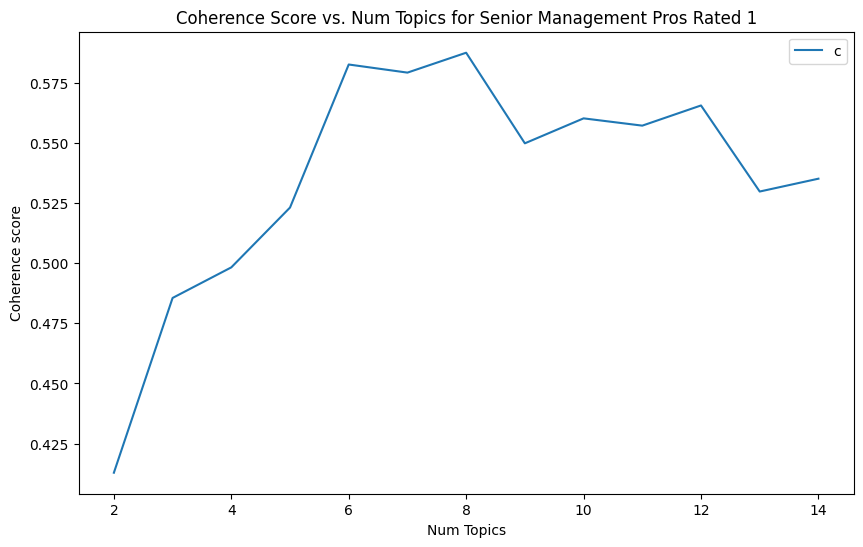

Optimal Model: LdaModel<num_terms=22239, num_topics=8, decay=0.5, chunksize=2000>

LDA Intertopic Visualization for Senior Management Pros Rated 1





MODELING LDA TOPICS FOR: Senior Management Pros Rated 3


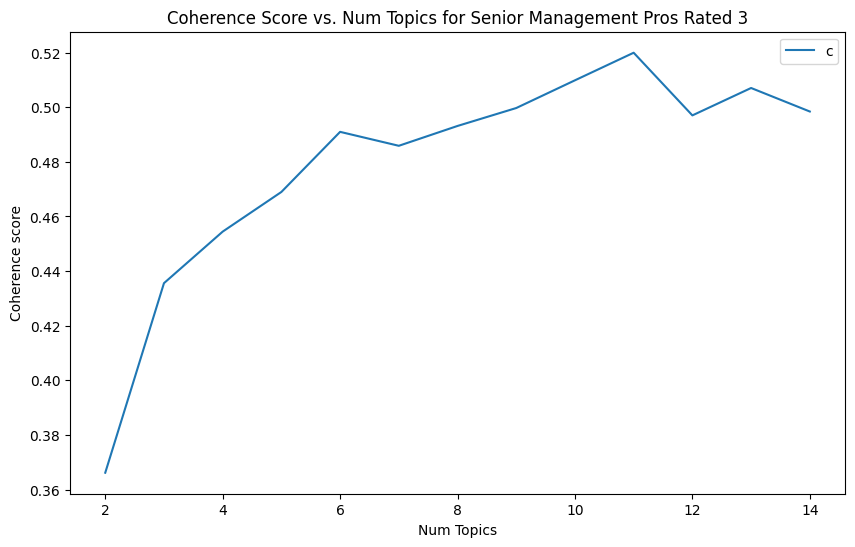

Optimal Model: LdaModel<num_terms=20261, num_topics=11, decay=0.5, chunksize=2000>

LDA Intertopic Visualization for Senior Management Pros Rated 3





MODELING LDA TOPICS FOR: Senior Management Pros Rated 5


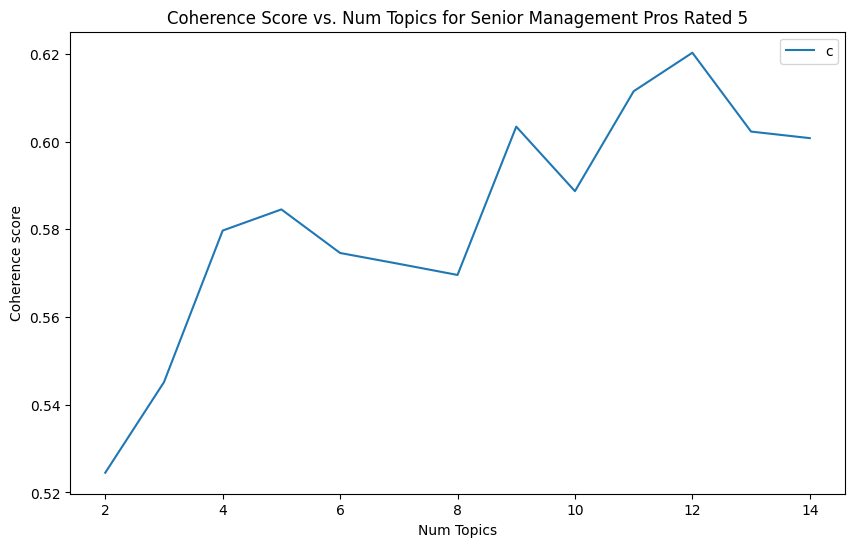

Optimal Model: LdaModel<num_terms=23695, num_topics=12, decay=0.5, chunksize=2000>

LDA Intertopic Visualization for Senior Management Pros Rated 5


In [ ]:
sm1_pros_lda_model, sm1_pros_coherence = prepare_lda_model(df_sm1_sample, 'pros_tokens', 'Senior Management Pros Rated 1')
sm3_pros_lda_model, sm3_pros_coherence = prepare_lda_model(df_sm3_sample, 'pros_tokens', 'Senior Management Pros Rated 3')
sm5_pros_lda_model, sm5_pros_coherence = prepare_lda_model(df_sm5_sample, 'pros_tokens', 'Senior Management Pros Rated 5')

MODELING LDA TOPICS FOR: Senior Management Cons Rated 1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


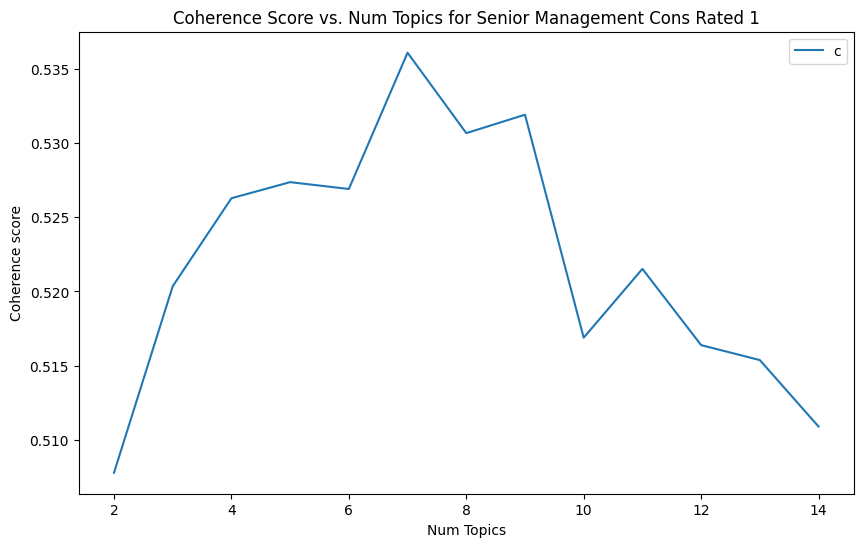

Optimal Model: LdaModel<num_terms=44117, num_topics=7, decay=0.5, chunksize=2000>

LDA Intertopic Visualization for Senior Management Cons Rated 1





MODELING LDA TOPICS FOR: Senior Management Cons Rated 3


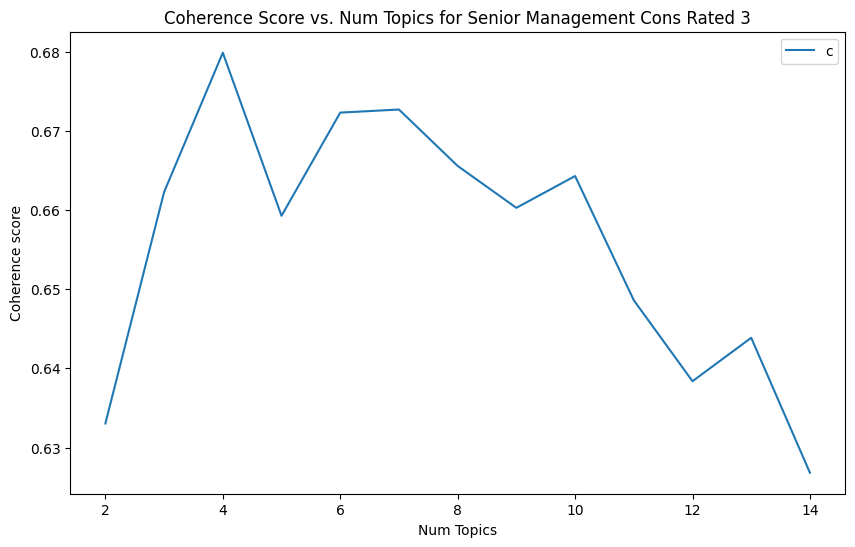

Optimal Model: LdaModel<num_terms=25953, num_topics=4, decay=0.5, chunksize=2000>

LDA Intertopic Visualization for Senior Management Cons Rated 3


/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:299: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  token_table['Freq'] = token_table['Freq'].round()





MODELING LDA TOPICS FOR: Senior Management Cons Rated 5


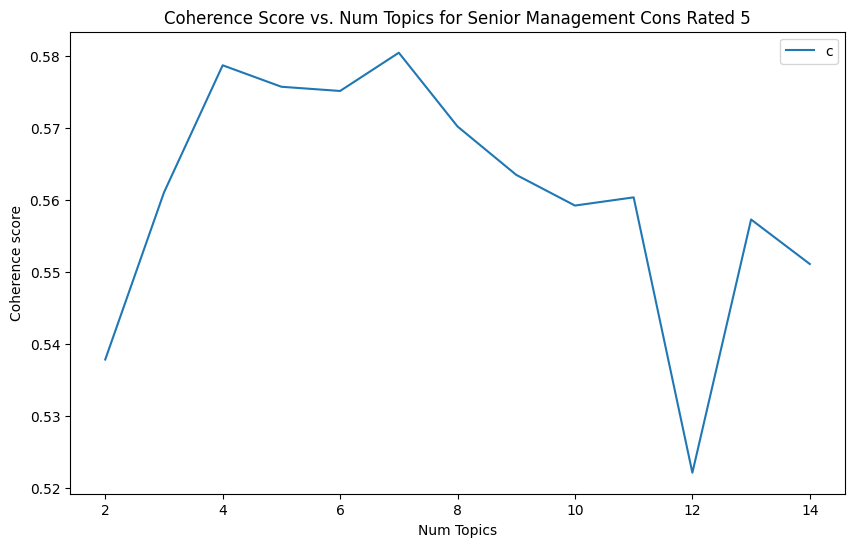

Optimal Model: LdaModel<num_terms=21147, num_topics=7, decay=0.5, chunksize=2000>

LDA Intertopic Visualization for Senior Management Cons Rated 5


In [ ]:
sm1_cons_lda_model, sm1_cons_coherence = prepare_lda_model(df_sm1_sample, 'cons_tokens', 'Senior Management Cons Rated 1')
sm3_cons_lda_model, sm3_cons_coherence = prepare_lda_model(df_sm3_sample, 'cons_tokens', 'Senior Management Cons Rated 3')
sm5_cons_lda_model, sm5_cons_coherence = prepare_lda_model(df_sm5_sample, 'cons_tokens', 'Senior Management Cons Rated 5')

MODELING LDA TOPICS FOR: CEO Approval Pros Positive


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


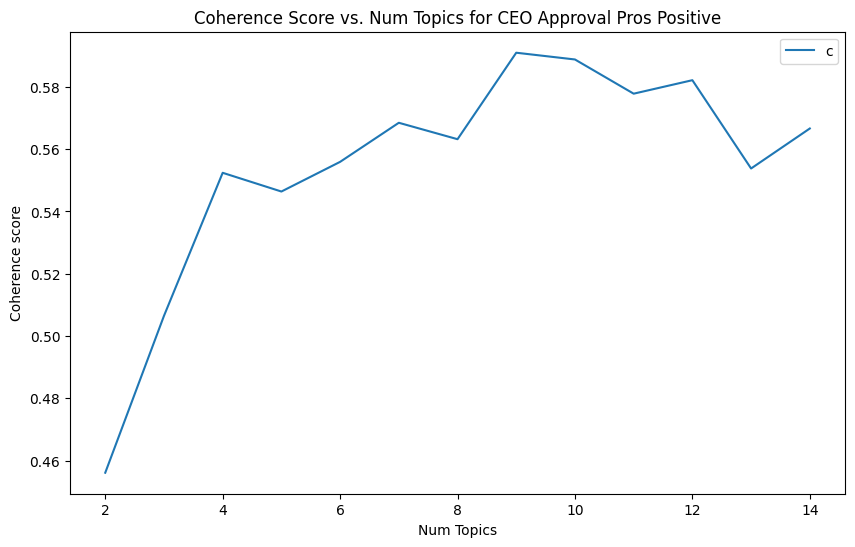

Optimal Model: LdaModel<num_terms=22942, num_topics=9, decay=0.5, chunksize=2000>

LDA Intertopic Visualization for CEO Approval Pros Positive





MODELING LDA TOPICS FOR: CEO Approval Pros Negative


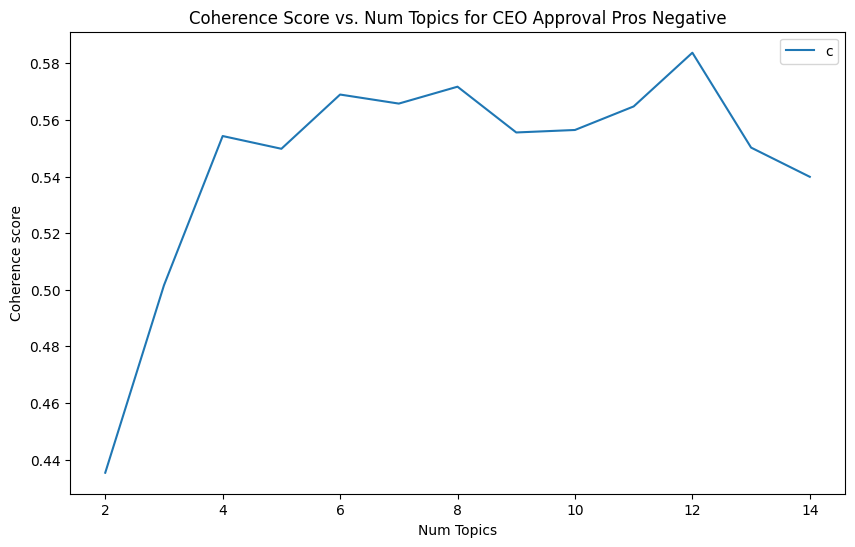

Optimal Model: LdaModel<num_terms=22829, num_topics=12, decay=0.5, chunksize=2000>

LDA Intertopic Visualization for CEO Approval Pros Negative





MODELING LDA TOPICS FOR: CEO Approval Pros Mild


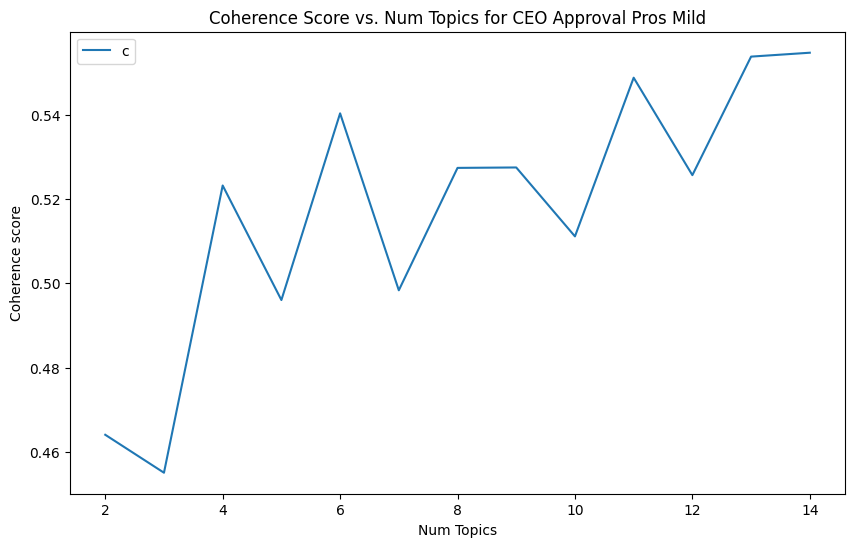

Optimal Model: LdaModel<num_terms=21490, num_topics=14, decay=0.5, chunksize=2000>

LDA Intertopic Visualization for CEO Approval Pros Mild


In [ ]:
ceo_pos_pros_lda_model, ceo_pos_pros_coherence = prepare_lda_model(df_ceo_approval_pos_sample, 'pros_tokens', 'CEO Approval Pros Positive')
ceo_neg_pros_lda_model, ceo_neg_pros_coherence = prepare_lda_model(df_ceo_approval_neg_sample, 'pros_tokens', 'CEO Approval Pros Negative')
ceo_mild_pros_lda_model, ceo_mild_pros_coherence = prepare_lda_model(df_ceo_approval_mild_sample, 'pros_tokens', 'CEO Approval Pros Mild')

MODELING LDA TOPICS FOR: CEO Approval Cons Positive


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


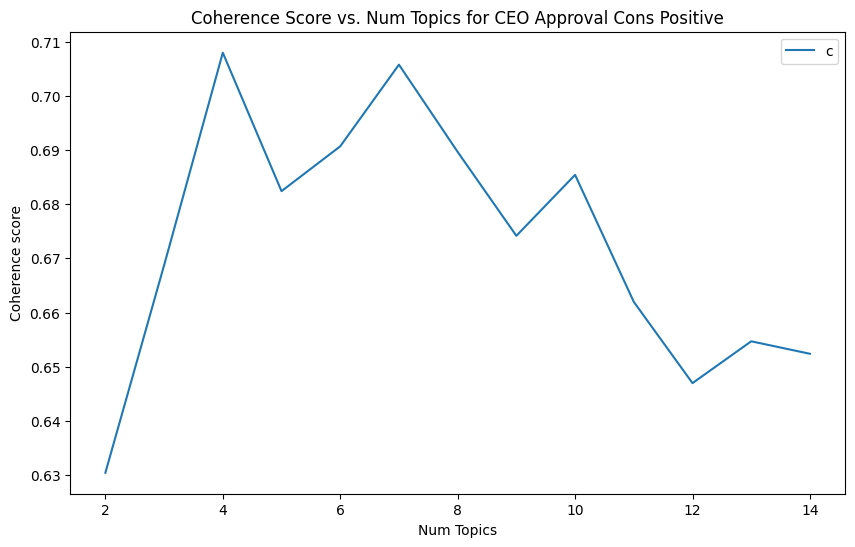

Optimal Model: LdaModel<num_terms=24753, num_topics=4, decay=0.5, chunksize=2000>

LDA Intertopic Visualization for CEO Approval Cons Positive





MODELING LDA TOPICS FOR: CEO Approval Cons Negative


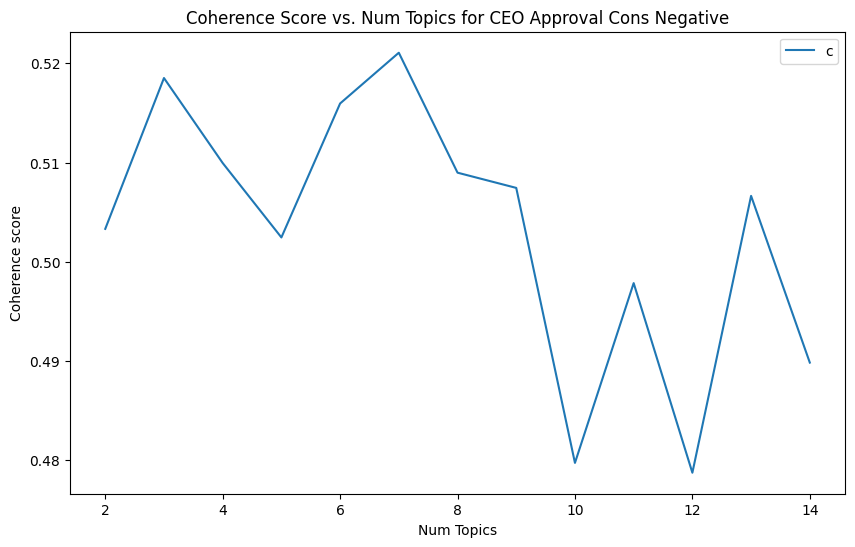

Optimal Model: LdaModel<num_terms=44714, num_topics=7, decay=0.5, chunksize=2000>

LDA Intertopic Visualization for CEO Approval Cons Negative





MODELING LDA TOPICS FOR: CEO Approval Cons Mild


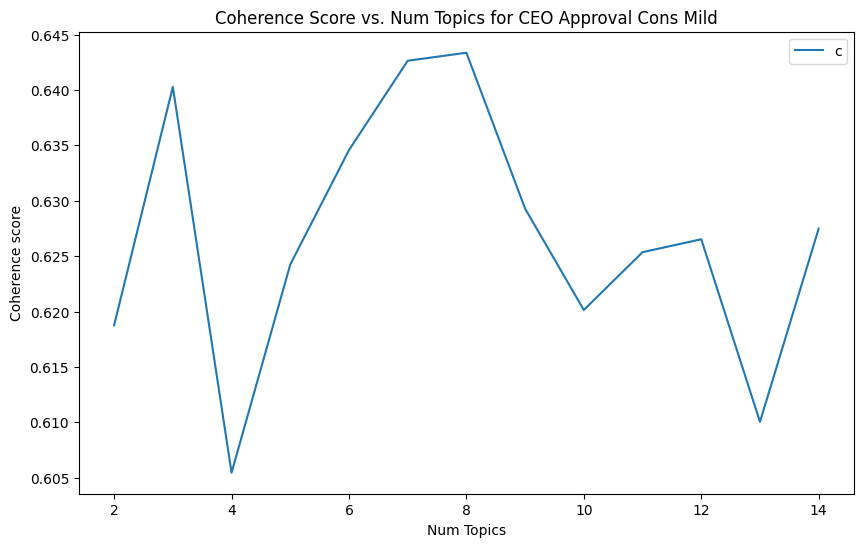

Optimal Model: LdaModel<num_terms=32655, num_topics=8, decay=0.5, chunksize=2000>

LDA Intertopic Visualization for CEO Approval Cons Mild


In [ ]:
ceo_pos_cons_lda_model, ceo_pos_cons_coherence = prepare_lda_model(df_ceo_approval_pos_sample, 'cons_tokens', 'CEO Approval Cons Positive')
ceo_neg_cons_lda_model, ceo_neg_cons_coherence = prepare_lda_model(df_ceo_approval_neg_sample, 'cons_tokens', 'CEO Approval Cons Negative')
ceo_mild_cons_lda_model, ceo_mild_cons_coherence = prepare_lda_model(df_ceo_approval_mild_sample, 'cons_tokens', 'CEO Approval Cons Mild')

MODELING LDA TOPICS FOR: Cons Rating 1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


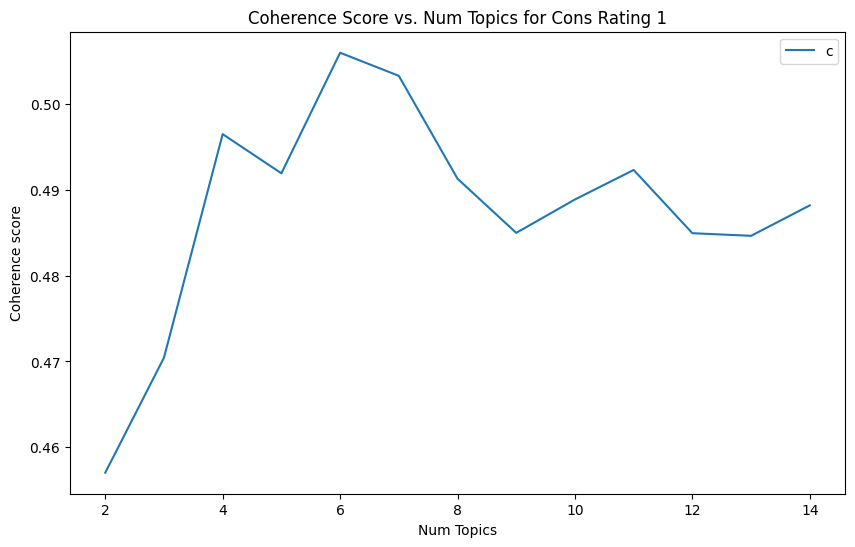

Optimal Model: LdaModel<num_terms=48549, num_topics=6, decay=0.5, chunksize=2000>

LDA Intertopic Visualization for Cons Rating 1





MODELING LDA TOPICS FOR: Pros Rating 5


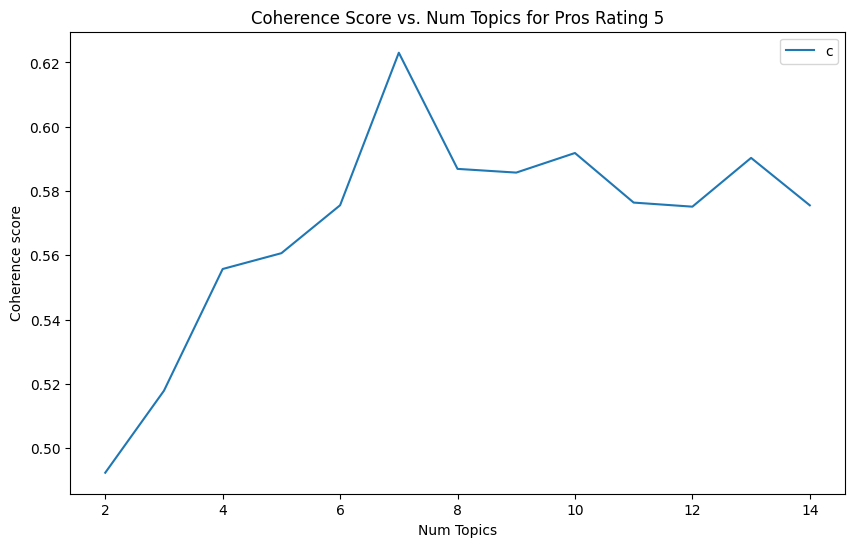

Optimal Model: LdaModel<num_terms=21833, num_topics=7, decay=0.5, chunksize=2000>

LDA Intertopic Visualization for Pros Rating 5


In [ ]:
cons1_lda_model, cons1_coherence = prepare_lda_model(df_cons1_sample, 'cons_tokens', 'Cons Rating 1')
pros5_lda_model, pros5_coherence = prepare_lda_model(df_pros5_sample, 'pros_tokens', 'Pros Rating 5')